## Network properties on reconstructed networks

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from src import network_properties
from tqdm import tqdm
from matplotlib import pyplot as plt
import igraph as ig
import numpy as np
from src import renormalizable_model
import scipy

Generate ground-truth network

In [41]:
sigma = 2.28
mu = -(sigma**2)/2
size = 500
gen_strengths = np.random.lognormal(mean=mu, sigma=sigma, size=size)
strengths = np.stack([gen_strengths, gen_strengths], axis=1)
z = 0.1

In [42]:
original_graph = renormalizable_model.create_RM_graph(strengths, z)
# connected = False
# while not connected:
#     original_graph = renormalizable_model.create_RM_graph(strengths, z)
#     connected = original_graph.is_connected()

Infer z value

In [43]:
num_of_links = original_graph.ecount()
in_strengths = original_graph.strength(mode='in', weights=original_graph.es["weight"])
out_strengths = original_graph.strength(mode='out', weights=original_graph.es["weight"])
def exp_num_of_links(z):
    return np.sum([1 - np.exp(-z*x_i*y_j) for x_i, y_j in np.array(np.meshgrid(out_strengths,in_strengths)).T.reshape(-1, 2)]) - num_of_links

In [44]:
exp_z_details = scipy.optimize.root_scalar(exp_num_of_links, method="bisect", bracket=[0,100])
print(exp_z_details)

      converged: True
           flag: converged
 function_calls: 48
     iterations: 46
           root: 0.10073487735695608


In [45]:
exp_z = exp_z_details.root

Generate ensemble using computed strengths

In [46]:
computed_strengths = np.stack([out_strengths, in_strengths], axis=1)
ensemble_size = 1000

In [47]:
ensemble = renormalizable_model.generate_RM_ensemble(ensemble_size, computed_strengths, exp_z, weighted = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [04:03<00:00,  4.10it/s]


## Network properties on coarse-grained networks

We merge part of nodes in one supernode while keeping the rest untouched.

We merge 50, 100 and 200 nodes.

In [48]:
from src import coarse_graining

### Low-level coarse-graining

Compute new weights from initial weights for every graph in the reconstructed ensemble.

In [49]:
coarse_grained_original_50 = coarse_graining.coarse_grain_weighted_graph(original_graph, coarse_graining.merge_n_group(original_graph, 50))
coarse_grained_original_100 = coarse_graining.coarse_grain_weighted_graph(original_graph, coarse_graining.merge_n_group(original_graph, 100))
coarse_grained_original_200 = coarse_graining.coarse_grain_weighted_graph(original_graph, coarse_graining.merge_n_group(original_graph, 200))
coarse_grained_original_400 = coarse_graining.coarse_grain_weighted_graph(original_graph, coarse_graining.merge_n_group(original_graph, 400))

In [50]:
coarse_grained_ensemble_50 = [coarse_graining.coarse_grain_weighted_graph(graph, coarse_graining.merge_n_group(graph, 50)) for graph in tqdm(ensemble)]
coarse_grained_ensemble_100 = [coarse_graining.coarse_grain_weighted_graph(graph, coarse_graining.merge_n_group(graph, 100)) for graph in tqdm(ensemble)]
coarse_grained_ensemble_200 = [coarse_graining.coarse_grain_weighted_graph(graph, coarse_graining.merge_n_group(graph, 200)) for graph in tqdm(ensemble)]
coarse_grained_ensemble_400 = [coarse_graining.coarse_grain_weighted_graph(graph, coarse_graining.merge_n_group(graph, 400)) for graph in tqdm(ensemble)]

100%|██████████| 1000/1000 [00:35<00:00, 28.08it/s]


In [51]:
out_strengths_50, in_strengths_50 = coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 50)).T
out_strengths_100, in_strengths_100 = coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 100)).T
out_strengths_200, in_strengths_200 = coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 200)).T
out_strengths_400, in_strengths_400 = coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 400)).T

#### Degrees

In [52]:
exp_degrees_out = np.nanmean([graph.degree(mode="out") for graph in ensemble], axis=0)
exp_degrees_out_50 = np.nanmean([graph.degree(mode="out") for graph in coarse_grained_ensemble_50], axis=0)
exp_degrees_out_100 = np.nanmean([graph.degree(mode="out") for graph in coarse_grained_ensemble_100], axis=0)
exp_degrees_out_200 = np.nanmean([graph.degree(mode="out") for graph in coarse_grained_ensemble_200], axis=0)
exp_degrees_out_400 = np.nanmean([graph.degree(mode="out") for graph in coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/1372676429.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), original_graph.degree(mode="out"), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/1372676429.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), exp_degrees_out, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/1372676429.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), coarse_grained_original_50.degree(mode="out"), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/1372676429.py:10: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), exp_degrees_out_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/1372676429.py:1

[Text(0.5, 0, '$\\log(s_0^{out})$')]

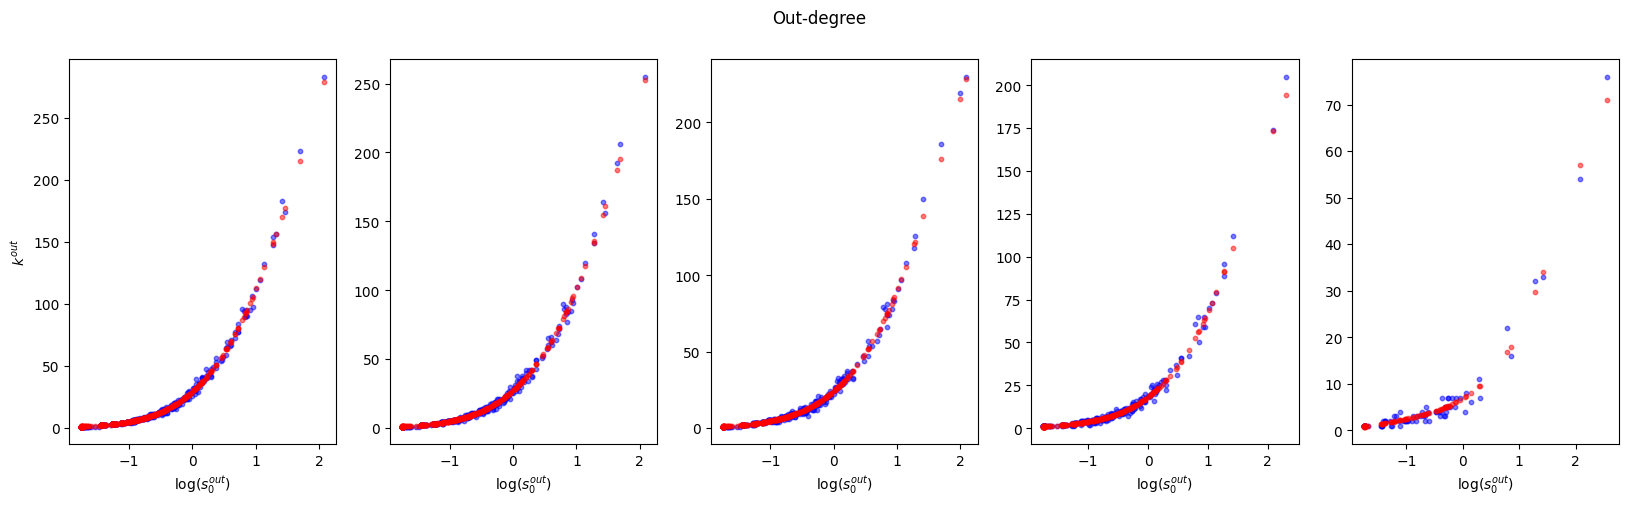

In [53]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Out-degree')


ax1.scatter(np.log10(out_strengths), original_graph.degree(mode="out"), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(out_strengths), exp_degrees_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{out})$", ylabel=r"$k^{out}$")

ax2.scatter(np.log10(out_strengths_50), coarse_grained_original_50.degree(mode="out"), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(out_strengths_50), exp_degrees_out_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{out})$")

ax3.scatter(np.log10(out_strengths_100), coarse_grained_original_100.degree(mode="out"), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(out_strengths_100), exp_degrees_out_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{out})$")

ax4.scatter(np.log10(out_strengths_200), coarse_grained_original_200.degree(mode="out"), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(out_strengths_200), exp_degrees_out_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{out})$")

ax5.scatter(np.log10(out_strengths_400), coarse_grained_original_400.degree(mode="out"), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(out_strengths_400), exp_degrees_out_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{out})$")


In [54]:
exp_degrees_in = np.nanmean([graph.degree(mode="in") for graph in ensemble], axis=0)
exp_degrees_in_50 = np.nanmean([graph.degree(mode="in") for graph in coarse_grained_ensemble_50], axis=0)
exp_degrees_in_100 = np.nanmean([graph.degree(mode="in") for graph in coarse_grained_ensemble_100], axis=0)
exp_degrees_in_200 = np.nanmean([graph.degree(mode="in") for graph in coarse_grained_ensemble_200], axis=0)
exp_degrees_in_400 = np.nanmean([graph.degree(mode="in") for graph in coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2610784528.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), original_graph.degree(mode="in"), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2610784528.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), exp_degrees_in, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2610784528.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), coarse_grained_original_50.degree(mode="in"), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2610784528.py:10: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), exp_degrees_in_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2610784528.py:13: Runti

[Text(0.5, 0, '$\\log(s_0^{in})$')]

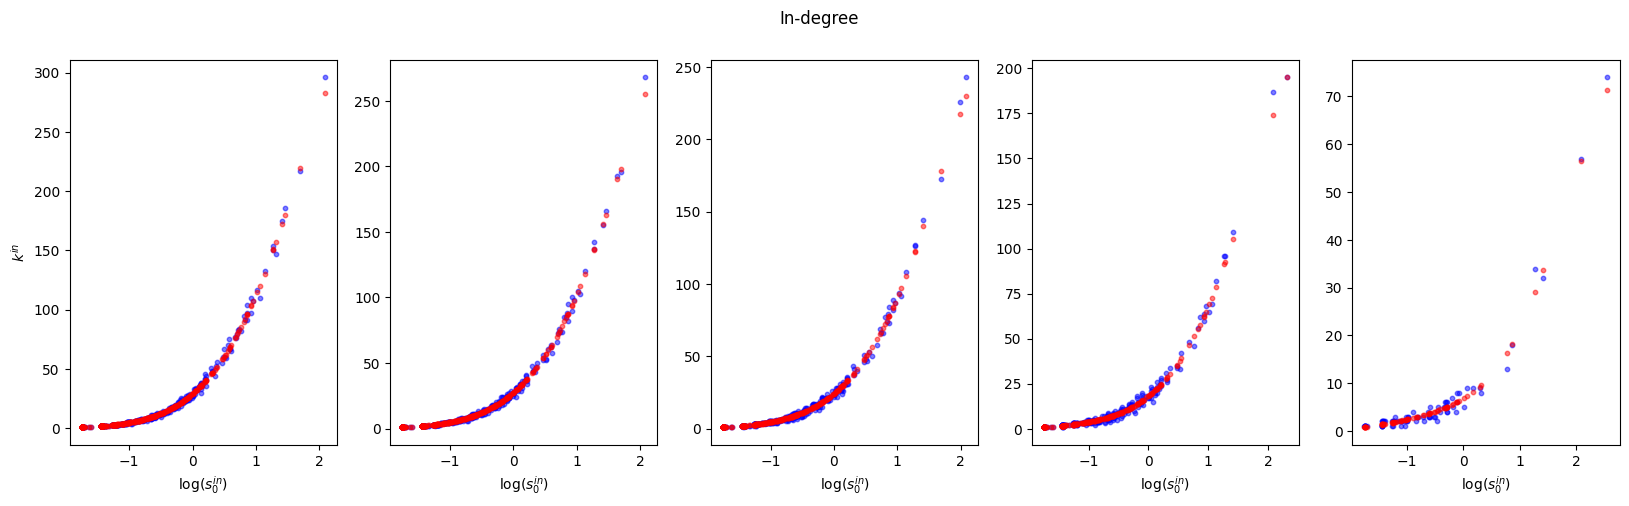

In [55]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('In-degree')


ax1.scatter(np.log10(in_strengths), original_graph.degree(mode="in"), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), exp_degrees_in, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$k^{in}$")

ax2.scatter(np.log10(in_strengths_50), coarse_grained_original_50.degree(mode="in"), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), exp_degrees_in_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), coarse_grained_original_100.degree(mode="in"), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), exp_degrees_in_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), coarse_grained_original_200.degree(mode="in"), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), exp_degrees_in_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), coarse_grained_original_400.degree(mode="in"), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), exp_degrees_in_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")


#### Strengths

In [56]:
exp_strengths_out = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in ensemble], axis=0)
exp_strengths_out_50 = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in coarse_grained_ensemble_50], axis=0)
exp_strengths_out_100 = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in coarse_grained_ensemble_100], axis=0)
exp_strengths_out_200 = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in coarse_grained_ensemble_200], axis=0)
exp_strengths_out_400 = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/732616285.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), original_graph.strength(mode="out", weights=original_graph.es["weight"]), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/732616285.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), exp_strengths_out, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/732616285.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), coarse_grained_original_50.strength(mode="out", weights=coarse_grained_original_50.es["weight"]), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/732616285.py:10: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), exp_strengths_out_50, c="red", s=10, 

[Text(0.5, 0, '$\\log(s_0^{out})$'), None]

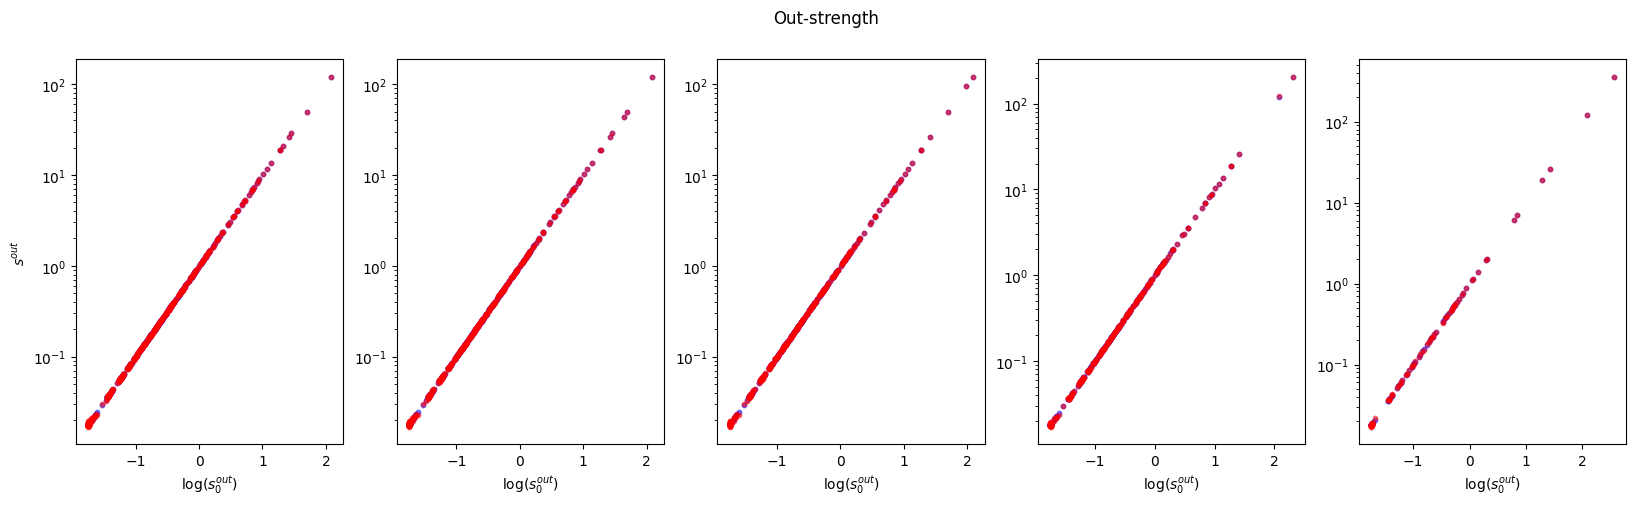

In [57]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Out-strength')


ax1.scatter(np.log10(out_strengths), original_graph.strength(mode="out", weights=original_graph.es["weight"]), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(out_strengths), exp_strengths_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{out})$", ylabel=r"$s^{out}$", yscale="log")

ax2.scatter(np.log10(out_strengths_50), coarse_grained_original_50.strength(mode="out", weights=coarse_grained_original_50.es["weight"]), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(out_strengths_50), exp_strengths_out_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{out})$", yscale="log")

ax3.scatter(np.log10(out_strengths_100), coarse_grained_original_100.strength(mode="out", weights=coarse_grained_original_100.es["weight"]), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(out_strengths_100), exp_strengths_out_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{out})$", yscale="log")

ax4.scatter(np.log10(out_strengths_200), coarse_grained_original_200.strength(mode="out", weights=coarse_grained_original_200.es["weight"]), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(out_strengths_200), exp_strengths_out_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{out})$", yscale="log")

ax5.scatter(np.log10(out_strengths_400), coarse_grained_original_400.strength(mode="out", weights=coarse_grained_original_400.es["weight"]), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(out_strengths_400), exp_strengths_out_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{out})$", yscale="log")

In [58]:
exp_strengths_in = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in ensemble], axis=0)
exp_strengths_in_50 = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in coarse_grained_ensemble_50], axis=0)
exp_strengths_in_100 = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in coarse_grained_ensemble_100], axis=0)
exp_strengths_in_200 = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in coarse_grained_ensemble_200], axis=0)
exp_strengths_in_400 = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/4213294502.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), original_graph.strength(mode="in", weights=original_graph.es["weight"]), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/4213294502.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), exp_strengths_in, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/4213294502.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), coarse_grained_original_50.strength(mode="in", weights=coarse_grained_original_50.es["weight"]), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/4213294502.py:10: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), exp_strengths_in_50, c="red", s=10, alph

[Text(0.5, 0, '$\\log(s_0^{in})$'), None]

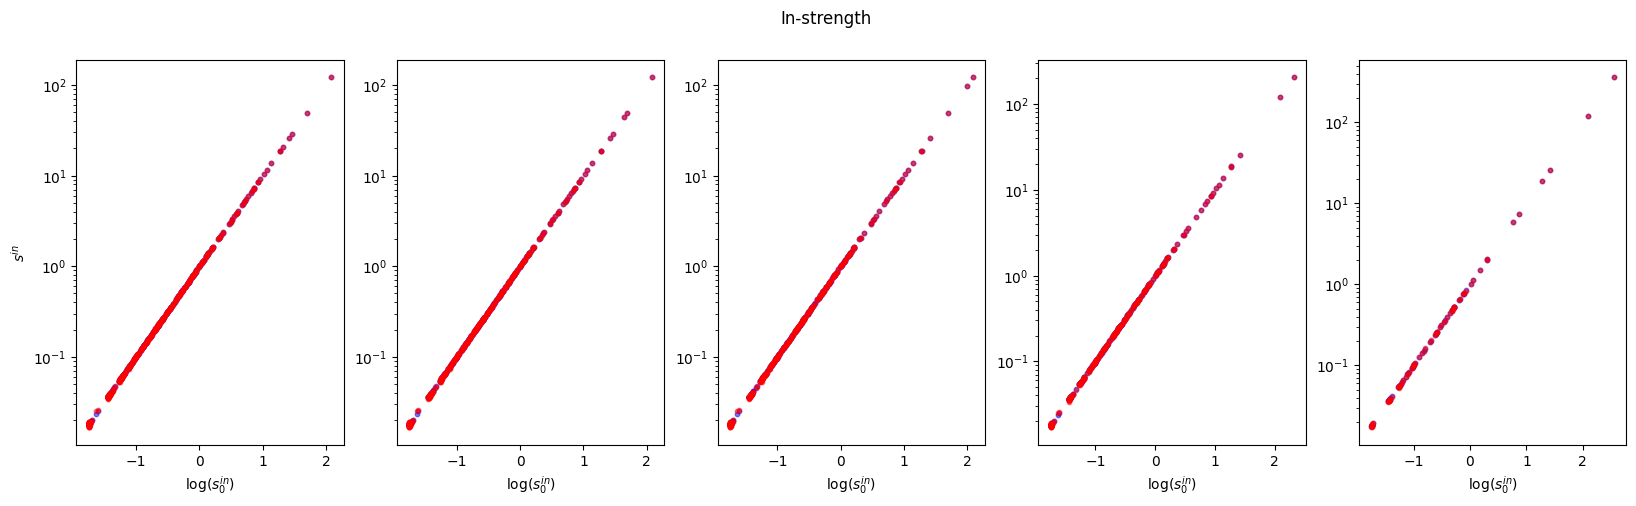

In [59]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('In-strength')


ax1.scatter(np.log10(in_strengths), original_graph.strength(mode="in", weights=original_graph.es["weight"]), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), exp_strengths_in, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$s^{in}$", yscale="log")

ax2.scatter(np.log10(in_strengths_50), coarse_grained_original_50.strength(mode="in", weights=coarse_grained_original_50.es["weight"]), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), exp_strengths_in_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$", yscale="log")

ax3.scatter(np.log10(in_strengths_100), coarse_grained_original_100.strength(mode="in", weights=coarse_grained_original_100.es["weight"]), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), exp_strengths_in_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$", yscale="log")

ax4.scatter(np.log10(in_strengths_200), coarse_grained_original_200.strength(mode="in", weights=coarse_grained_original_200.es["weight"]), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), exp_strengths_in_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$", yscale="log")

ax5.scatter(np.log10(in_strengths_400), coarse_grained_original_400.strength(mode="in", weights=coarse_grained_original_400.es["weight"]), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), exp_strengths_in_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$", yscale="log")

#### Average nearest neighbor degree

In [60]:
exp_annd_out = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in ensemble], axis=0)
exp_annd_out_50 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_50], axis=0)
exp_annd_out_100 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_100], axis=0)
exp_annd_out_200 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_200], axis=0)
exp_annd_out_400 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3361036361.py:1: RuntimeWarning: Mean of empty slice
  exp_annd_out = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in ensemble], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3361036361.py:2: RuntimeWarning: Mean of empty slice
  exp_annd_out_50 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_50], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3361036361.py:3: RuntimeWarning: Mean of empty slice
  exp_annd_out_100 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_100], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3361036361.py:4: RuntimeWarning: Mean of empty slice
  exp_annd_out_200 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_200], axis=0)
/var/folders/td/zvch62c16b790gt_t

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2291278984.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), network_properties.annd(original_graph, mode="out")[0], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2291278984.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), exp_annd_out, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2291278984.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), network_properties.annd(coarse_grained_original_50, mode="out")[0], s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2291278984.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), exp_annd_out_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000g

[Text(0.5, 0, '$\\log(s_0^{out})$')]

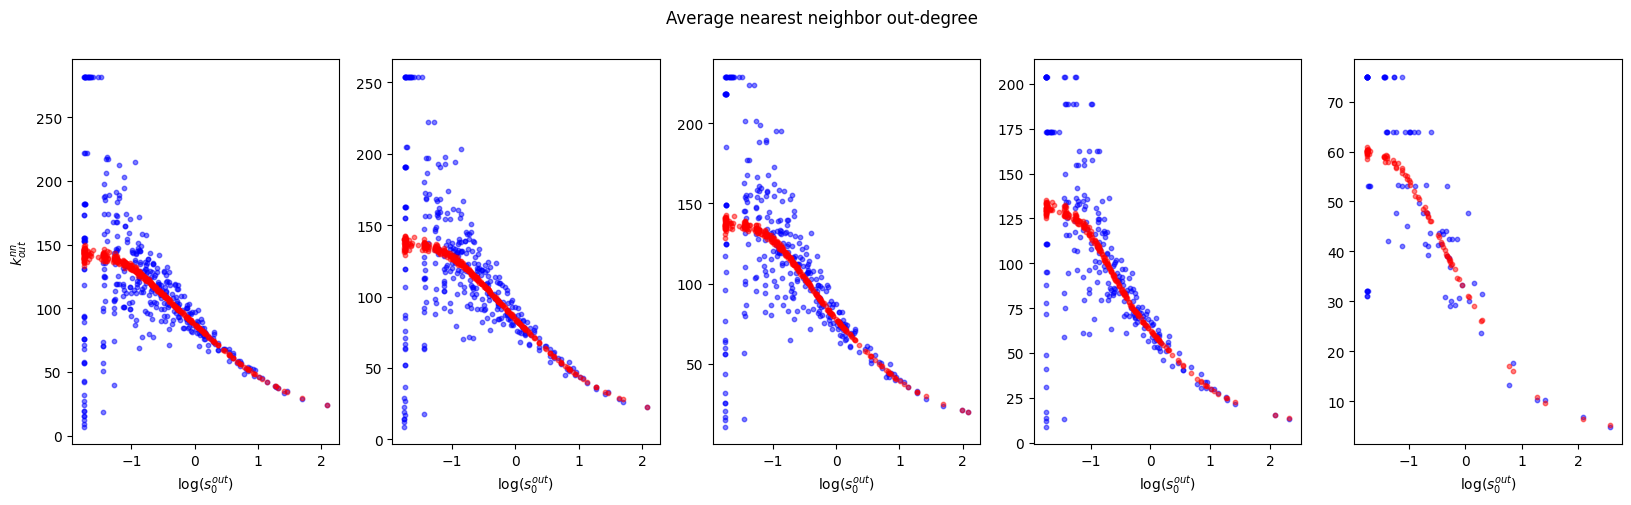

In [61]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average nearest neighbor out-degree')

ax1.scatter(np.log10(out_strengths), network_properties.annd(original_graph, mode="out")[0], s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(out_strengths), exp_annd_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{out})$", ylabel=r"$k^{nn}_{out}$")

ax2.scatter(np.log10(out_strengths_50), network_properties.annd(coarse_grained_original_50, mode="out")[0], s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(out_strengths_50), exp_annd_out_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{out})$")

ax3.scatter(np.log10(out_strengths_100), network_properties.annd(coarse_grained_original_100, mode="out")[0], s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(out_strengths_100), exp_annd_out_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{out})$")

ax4.scatter(np.log10(out_strengths_200), network_properties.annd(coarse_grained_original_200, mode="out")[0], s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(out_strengths_200), exp_annd_out_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{out})$")

ax5.scatter(np.log10(out_strengths_400), network_properties.annd(coarse_grained_original_400, mode="out")[0], s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(out_strengths_400), exp_annd_out_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{out})$")


In [62]:
exp_annd_in = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in ensemble], axis=0)
exp_annd_in_50 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in coarse_grained_ensemble_50], axis=0)
exp_annd_in_100 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in coarse_grained_ensemble_100], axis=0)
exp_annd_in_200 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in coarse_grained_ensemble_200], axis=0)
exp_annd_in_400 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3966756356.py:1: RuntimeWarning: Mean of empty slice
  exp_annd_in = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in ensemble], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3966756356.py:2: RuntimeWarning: Mean of empty slice
  exp_annd_in_50 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in coarse_grained_ensemble_50], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3966756356.py:3: RuntimeWarning: Mean of empty slice
  exp_annd_in_100 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in coarse_grained_ensemble_100], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3966756356.py:4: RuntimeWarning: Mean of empty slice
  exp_annd_in_200 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in coarse_grained_ensemble_200], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/4109011521.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.annd(original_graph, mode="in")[0], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/4109011521.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), exp_annd_in, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/4109011521.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.annd(coarse_grained_original_50, mode="in")[0], s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/4109011521.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), exp_annd_in_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipyk

[Text(0.5, 0, '$\\log(s_0^{in})$')]

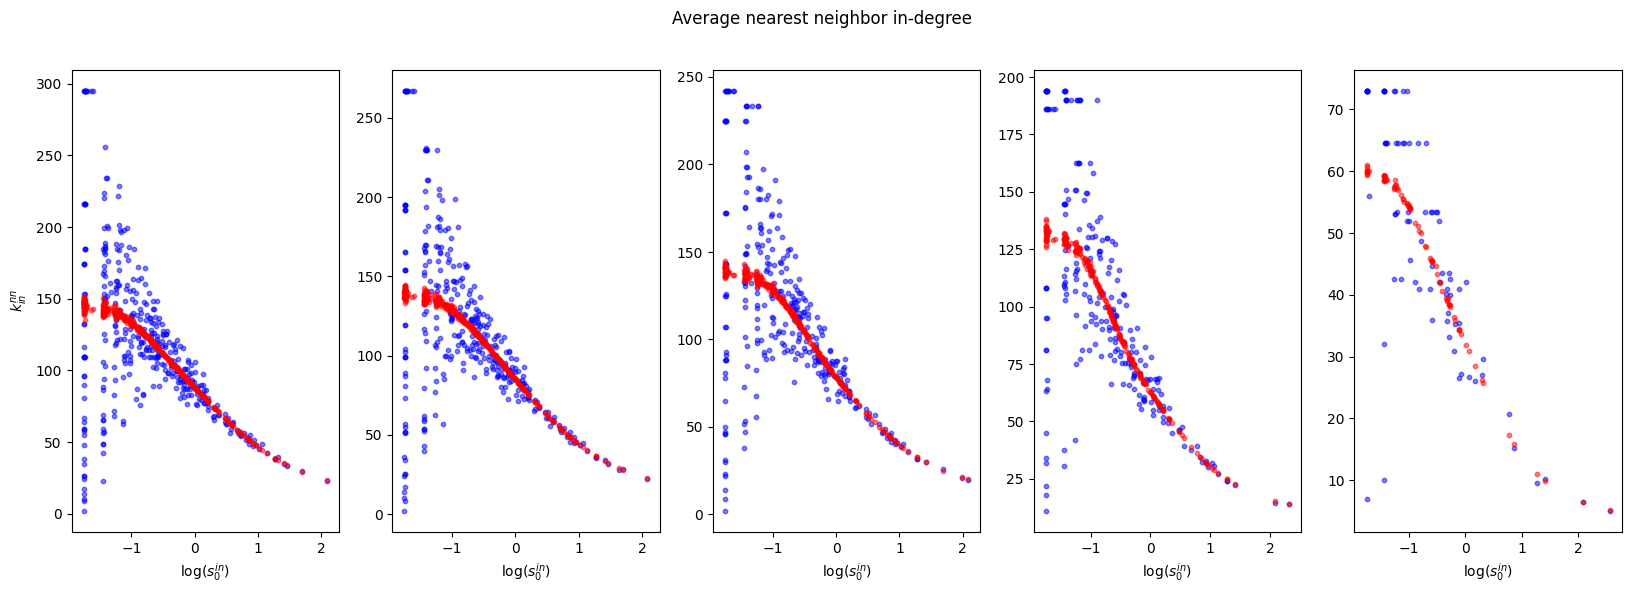

In [63]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle('Average nearest neighbor in-degree')

ax1.scatter(np.log10(in_strengths), network_properties.annd(original_graph, mode="in")[0], s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), exp_annd_in, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$k^{nn}_{in}$")

ax2.scatter(np.log10(in_strengths_50), network_properties.annd(coarse_grained_original_50, mode="in")[0], s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), exp_annd_in_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.annd(coarse_grained_original_100, mode="in")[0], s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), exp_annd_in_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.annd(coarse_grained_original_200, mode="in")[0], s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), exp_annd_in_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.annd(coarse_grained_original_400, mode="in")[0], s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), exp_annd_in_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

#### Average nearest neighbor strength

In [64]:
exp_anns_out = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(ensemble)], axis=0)
exp_anns_out_50 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(coarse_grained_ensemble_50)], axis=0)
exp_anns_out_100 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(coarse_grained_ensemble_100)], axis=0)
exp_anns_out_200 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(coarse_grained_ensemble_200)], axis=0)
exp_anns_out_400 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(coarse_grained_ensemble_400)], axis=0)

100%|██████████| 1000/1000 [03:53<00:00,  4.28it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2354909290.py:1: RuntimeWarning: Mean of empty slice
  exp_anns_out = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(ensemble)], axis=0)
 99%|█████████▉| 993/1000 [04:10<00:01,  3.96it/s]


KeyboardInterrupt: 

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3582338637.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), network_properties.anns(original_graph, mode="out"), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3582338637.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), exp_anns_out, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3582338637.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), network_properties.anns(coarse_grained_original_50, mode="out"), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3582338637.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), exp_anns_out_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ip

[Text(0.5, 0, '$\\log(s_0^{out})$')]

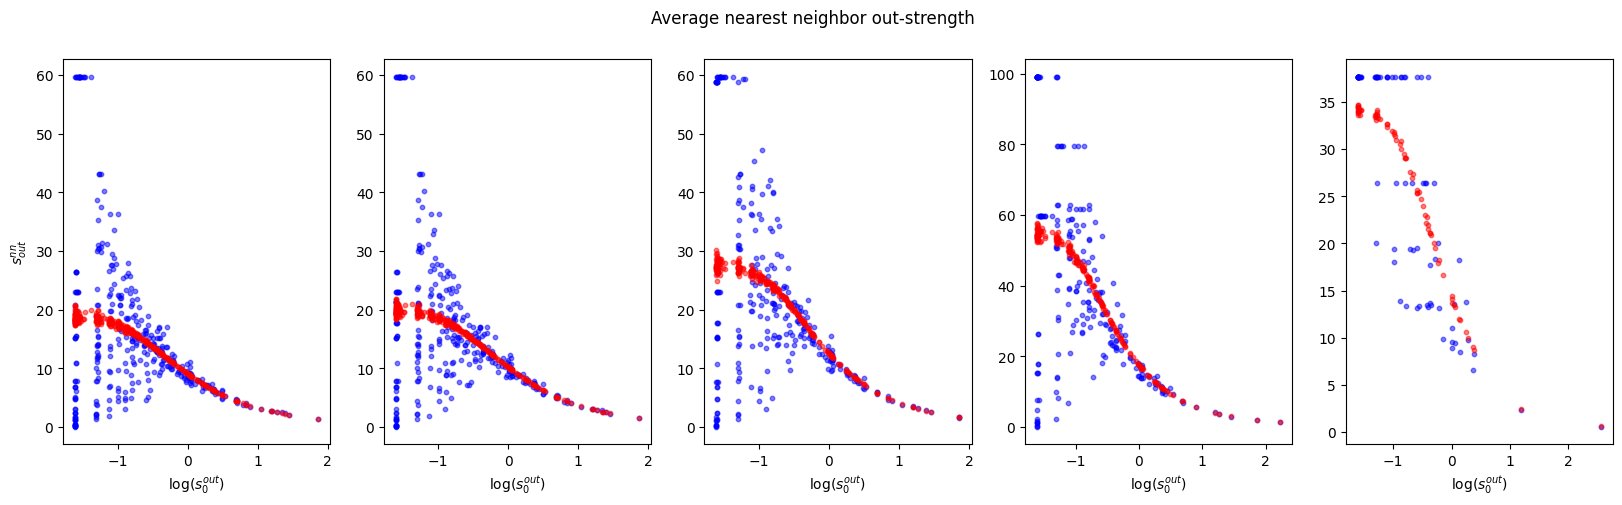

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average nearest neighbor out-strength')

ax1.scatter(np.log10(out_strengths), network_properties.anns(original_graph, mode="out"), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(out_strengths), exp_anns_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{out})$", ylabel=r"$s^{nn}_{out}$")

ax2.scatter(np.log10(out_strengths_50), network_properties.anns(coarse_grained_original_50, mode="out"), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(out_strengths_50), exp_anns_out_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{out})$")

ax3.scatter(np.log10(out_strengths_100), network_properties.anns(coarse_grained_original_100, mode="out"), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(out_strengths_100), exp_anns_out_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{out})$")

ax4.scatter(np.log10(out_strengths_200), network_properties.anns(coarse_grained_original_200, mode="out"), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(out_strengths_200), exp_anns_out_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{out})$")

ax5.scatter(np.log10(out_strengths_400), network_properties.anns(coarse_grained_original_400, mode="out"), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(out_strengths_400), exp_anns_out_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{out})$")

In [ ]:
exp_anns_in = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(ensemble)], axis=0)
exp_anns_in_50 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(coarse_grained_ensemble_50)], axis=0)
exp_anns_in_100 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(coarse_grained_ensemble_100)], axis=0)
exp_anns_in_200 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(coarse_grained_ensemble_200)], axis=0)
exp_anns_in_400 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(coarse_grained_ensemble_400)], axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:53: RuntimeWarning: invalid value encountered in divide
  result = np.sum(multiplied, axis=0)/np.sum(adj_matrix, axis=0)
100%|██████████| 1000/1000 [00:38<00:00, 25.65it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2408892964.py:1: RuntimeWarning: Mean of empty slice
  exp_anns_in = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(ensemble)], axis=0)
100%|██████████| 1000/1000 [00:34<00:00, 28.83it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2408892964.py:2: RuntimeWarning: Mean of empty slice
  exp_anns_in_50 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(coarse_grained_ensemble_50)], axis=0)
100%|██████████| 1000/1000 [00:27<00:00, 36.42it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/2408892964.py:3: RuntimeWarning: Mean 

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/1149421070.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.anns(original_graph, mode="in"), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/1149421070.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), exp_anns_in, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/1149421070.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.anns(coarse_grained_original_50, mode="in"), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/1149421070.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), exp_anns_in_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_

[Text(0.5, 0, '$\\log(s_0^{in})$')]

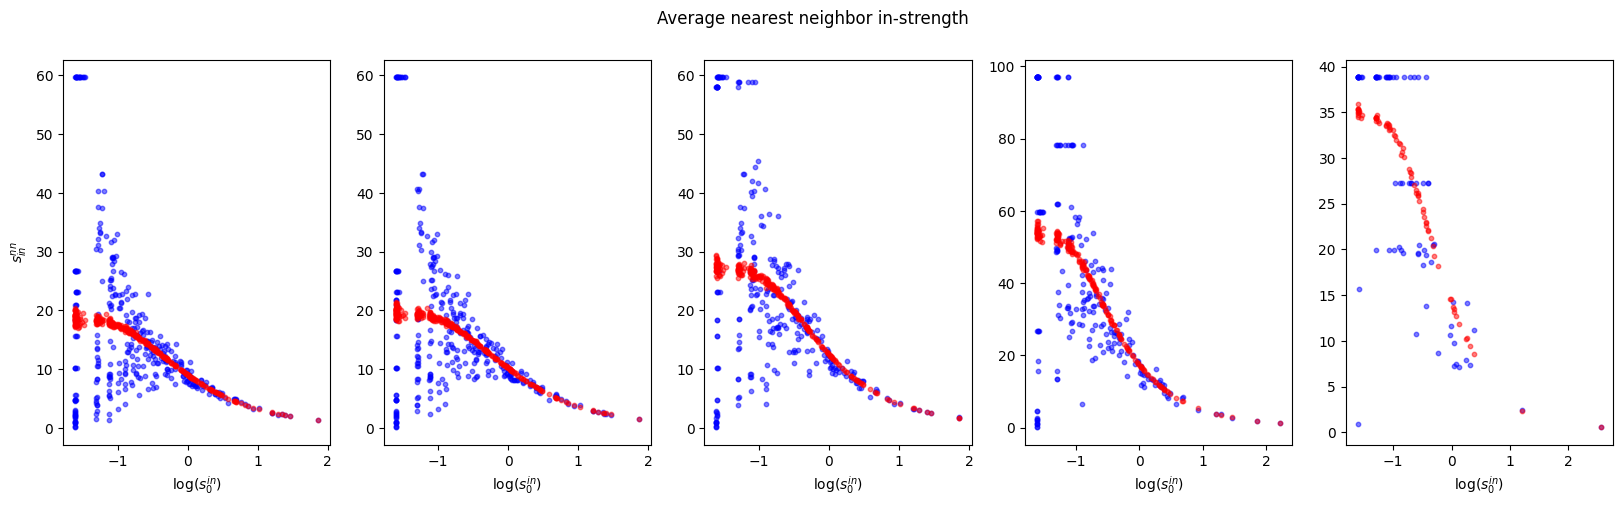

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average nearest neighbor in-strength')

ax1.scatter(np.log10(in_strengths), network_properties.anns(original_graph, mode="in"), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), exp_anns_in, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$s^{nn}_{in}$")

ax2.scatter(np.log10(in_strengths_50), network_properties.anns(coarse_grained_original_50, mode="in"), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), exp_anns_in_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.anns(coarse_grained_original_100, mode="in"), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), exp_anns_in_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.anns(coarse_grained_original_200, mode="in"), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), exp_anns_in_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.anns(coarse_grained_original_400, mode="in"), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), exp_anns_in_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

#### Clustering coefficient

In [ ]:
exp_cl_coeff_results = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(ensemble)]
exp_cl_coeff_results_50 = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(coarse_grained_ensemble_50)]
exp_cl_coeff_results_100 = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(coarse_grained_ensemble_100)]
exp_cl_coeff_results_200 = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(coarse_grained_ensemble_200)]
exp_cl_coeff_results_400 = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(coarse_grained_ensemble_400)]

  0%|          | 0/1000 [00:00<?, ?it/s]/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:91: RuntimeWarning: invalid value encountered in scalar divide
  clustering_coeff_array[i] = clustering_coeff_array[i]/num_wedges
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:94: RuntimeWarning: invalid value encountered in divide
  clustering_coeff_k = clustering_coeff_k/degree_hist
100%|██████████| 1000/1000 [00:01<00:00, 592.08it/s]


In [ ]:
exp_cl_coeff = np.nanmean([exp_cl_coeff_results[i][0] for i in range(len(exp_cl_coeff_results))], axis=0)
exp_cl_coeff_50 = np.nanmean([exp_cl_coeff_results_50[i][0] for i in range(len(exp_cl_coeff_results_50))], axis=0)
exp_cl_coeff_100 = np.nanmean([exp_cl_coeff_results_100[i][0] for i in range(len(exp_cl_coeff_results_100))], axis=0)
exp_cl_coeff_200 = np.nanmean([exp_cl_coeff_results_200[i][0] for i in range(len(exp_cl_coeff_results_200))], axis=0)
exp_cl_coeff_400 = np.nanmean([exp_cl_coeff_results_400[i][0] for i in range(len(exp_cl_coeff_results_400))], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/601958696.py:1: RuntimeWarning: Mean of empty slice
  exp_cl_coeff = np.nanmean([exp_cl_coeff_results[i][0] for i in range(len(exp_cl_coeff_results))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/601958696.py:2: RuntimeWarning: Mean of empty slice
  exp_cl_coeff_50 = np.nanmean([exp_cl_coeff_results_50[i][0] for i in range(len(exp_cl_coeff_results_50))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/601958696.py:3: RuntimeWarning: Mean of empty slice
  exp_cl_coeff_100 = np.nanmean([exp_cl_coeff_results_100[i][0] for i in range(len(exp_cl_coeff_results_100))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/601958696.py:4: RuntimeWarning: Mean of empty slice
  exp_cl_coeff_200 = np.nanmean([exp_cl_coeff_results_200[i][0] for i in range(len(exp_cl_coeff_results_200))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/60

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/52025126.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.clustering_coeff(original_graph,len_deg_seq=size)[0], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/52025126.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), exp_cl_coeff, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/52025126.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.clustering_coeff(coarse_grained_original_50,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/52025126.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), exp_cl_coeff_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c

[Text(0.5, 0, '$\\log(s_0^{in})$')]

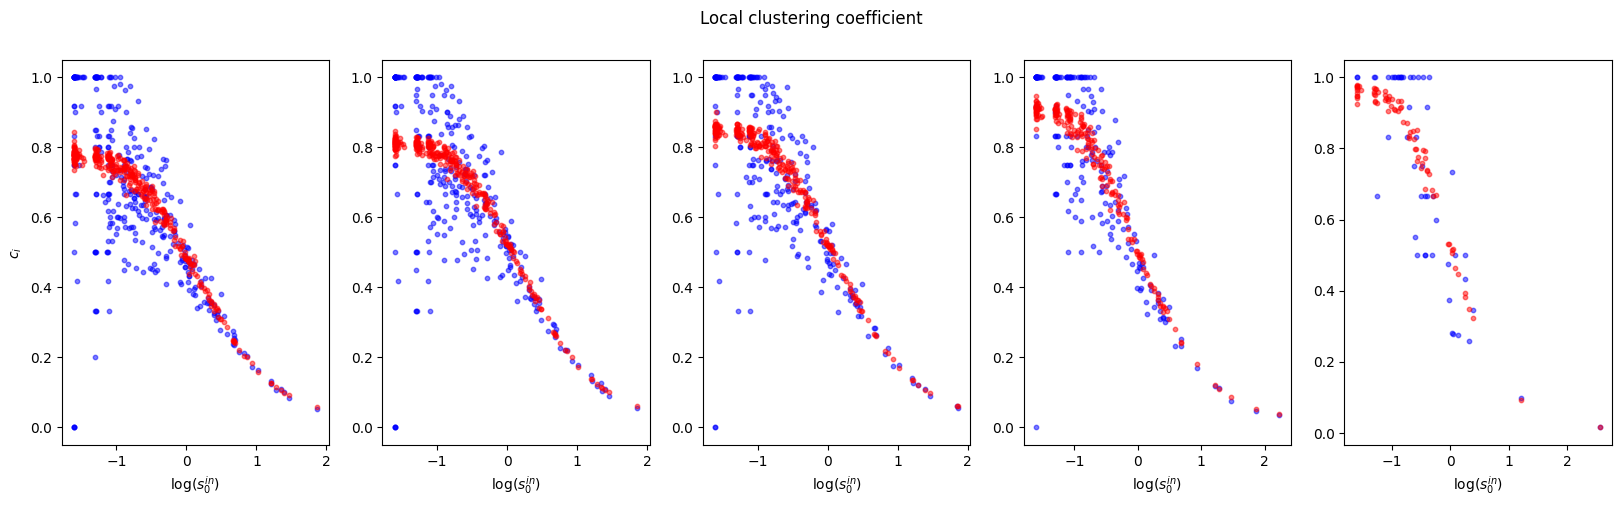

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Local clustering coefficient')

ax1.scatter(np.log10(in_strengths), network_properties.clustering_coeff(original_graph,len_deg_seq=size)[0], s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), exp_cl_coeff, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$c_i$")

ax2.scatter(np.log10(in_strengths_50), network_properties.clustering_coeff(coarse_grained_original_50,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), exp_cl_coeff_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.clustering_coeff(coarse_grained_original_100,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), exp_cl_coeff_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.clustering_coeff(coarse_grained_original_200,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), exp_cl_coeff_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.clustering_coeff(coarse_grained_original_400,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), exp_cl_coeff_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

In [ ]:
exp_cl_coeff_k = np.nanmean([exp_cl_coeff_results[i][1] for i in range(len(exp_cl_coeff_results))], axis=0)
exp_cl_coeff_k_50 = np.nanmean([exp_cl_coeff_results_50[i][1] for i in range(len(exp_cl_coeff_results_50))], axis=0)
exp_cl_coeff_k_100 = np.nanmean([exp_cl_coeff_results_100[i][1] for i in range(len(exp_cl_coeff_results_100))], axis=0)
exp_cl_coeff_k_200 = np.nanmean([exp_cl_coeff_results_200[i][1] for i in range(len(exp_cl_coeff_results_200))], axis=0)
exp_cl_coeff_k_400 = np.nanmean([exp_cl_coeff_results_400[i][1] for i in range(len(exp_cl_coeff_results_400))], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/256659897.py:1: RuntimeWarning: Mean of empty slice
  exp_cl_coeff_k = np.nanmean([exp_cl_coeff_results[i][1] for i in range(len(exp_cl_coeff_results))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/256659897.py:2: RuntimeWarning: Mean of empty slice
  exp_cl_coeff_k_50 = np.nanmean([exp_cl_coeff_results_50[i][1] for i in range(len(exp_cl_coeff_results_50))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/256659897.py:3: RuntimeWarning: Mean of empty slice
  exp_cl_coeff_k_100 = np.nanmean([exp_cl_coeff_results_100[i][1] for i in range(len(exp_cl_coeff_results_100))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/256659897.py:4: RuntimeWarning: Mean of empty slice
  exp_cl_coeff_k_200 = np.nanmean([exp_cl_coeff_results_200[i][1] for i in range(len(exp_cl_coeff_results_200))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_

In [ ]:
obs_cl_coeff_k = network_properties.clustering_coeff(original_graph, len_deg_seq=size)[1]
obs_cl_coeff_k_50 = network_properties.clustering_coeff(coarse_grained_original_50, len_deg_seq=size)[1]
obs_cl_coeff_k_100 = network_properties.clustering_coeff(coarse_grained_original_100, len_deg_seq=size)[1]
obs_cl_coeff_k_200 = network_properties.clustering_coeff(coarse_grained_original_200, len_deg_seq=size)[1]
obs_cl_coeff_k_400 = network_properties.clustering_coeff(coarse_grained_original_400, len_deg_seq=size)[1]

[Text(0.5, 0, '$k$'), None, None]

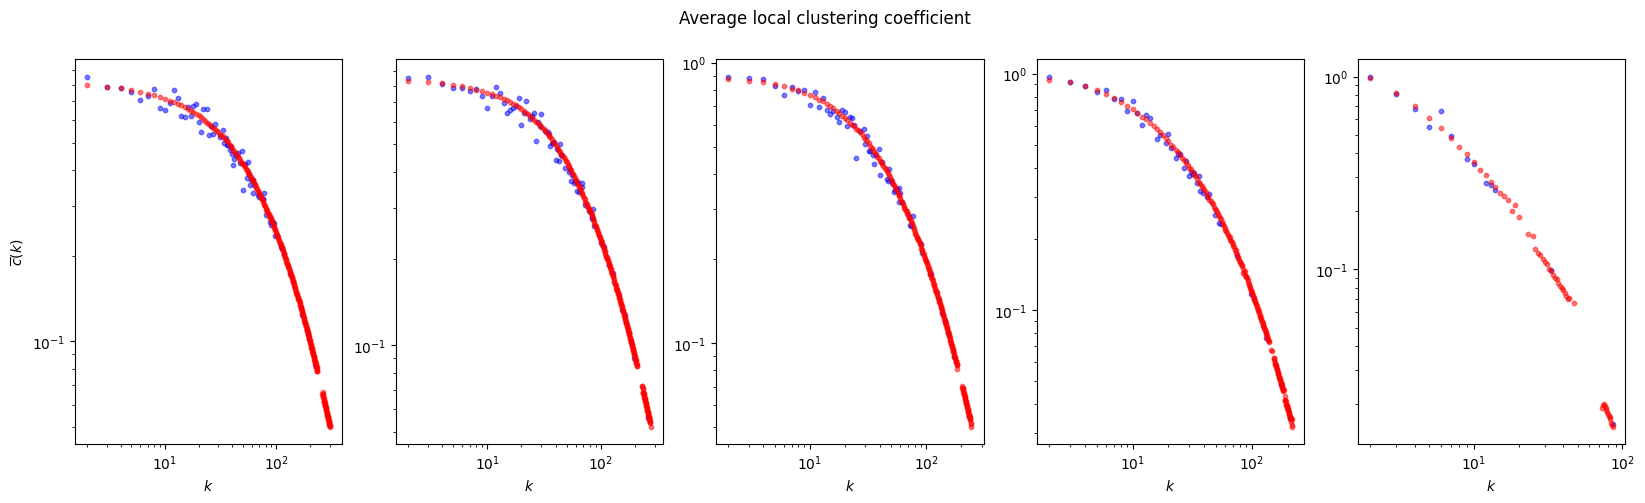

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average local clustering coefficient')

ax1.scatter(range(1, len(obs_cl_coeff_k)+1), obs_cl_coeff_k, s=10, c="blue", alpha=.5)
ax1.scatter(range(1, len(exp_cl_coeff_k)+1), exp_cl_coeff_k, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$k$", ylabel=r'$\overline{c}(k)$', xscale="log", yscale="log")

ax2.scatter(range(1, len(obs_cl_coeff_k_50)+1), obs_cl_coeff_k_50, s=10, c="blue", alpha=.5)
ax2.scatter(range(1, len(exp_cl_coeff_k_50)+1), exp_cl_coeff_k_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$k$", xscale="log", yscale="log")

ax3.scatter(range(1, len(obs_cl_coeff_k_100)+1), obs_cl_coeff_k_100, s=10, c="blue", alpha=.5)
ax3.scatter(range(1, len(exp_cl_coeff_k_100)+1), exp_cl_coeff_k_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$k$", xscale="log", yscale="log")

ax4.scatter(range(1, len(obs_cl_coeff_k_200)+1), obs_cl_coeff_k_200, s=10, c="blue", alpha=.5)
ax4.scatter(range(1, len(exp_cl_coeff_k_200)+1), exp_cl_coeff_k_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$k$", xscale="log", yscale="log")

ax5.scatter(range(1, len(obs_cl_coeff_k_400)+1), obs_cl_coeff_k_400, s=10, c="blue", alpha=.5)
ax5.scatter(range(1, len(exp_cl_coeff_k_400)+1), exp_cl_coeff_k_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$k$", xscale="log", yscale="log")

#### Weighted clustering coefficient

In [ ]:
exp_weighted_cl_coeff = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(ensemble)], axis=0)
exp_weighted_cl_coeff_50 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(coarse_grained_ensemble_50)], axis=0)
exp_weighted_cl_coeff_100 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(coarse_grained_ensemble_100)], axis=0)
exp_weighted_cl_coeff_200 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(coarse_grained_ensemble_200)], axis=0)
exp_weighted_cl_coeff_400 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(coarse_grained_ensemble_400)], axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:119: RuntimeWarning: invalid value encountered in scalar divide
  w_cl_coeff_array[i] = w_cl_coeff_array[i]/num_wedges
100%|██████████| 1000/1000 [03:20<00:00,  5.00it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3344557992.py:1: RuntimeWarning: Mean of empty slice
  exp_weighted_cl_coeff = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(ensemble)], axis=0)
100%|██████████| 1000/1000 [02:50<00:00,  5.87it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/3344557992.py:2: RuntimeWarning: Mean of empty slice
  exp_weighted_cl_coeff_50 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(coarse_grained_ensemble_50)], axis=0)
100%|██████████| 1000/1000 [01:56<00:00,  8.62it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/4146884286.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.weighted_clustering_coeff(original_graph), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/4146884286.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), exp_weighted_cl_coeff, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/4146884286.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.weighted_clustering_coeff(coarse_grained_original_50), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75095/4146884286.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), exp_weighted_cl_coeff_50, c="red", s=10, alpha=.5)
/var/folders/td/zvc

[Text(0.5, 0, '$\\log(s_0^{in})$')]

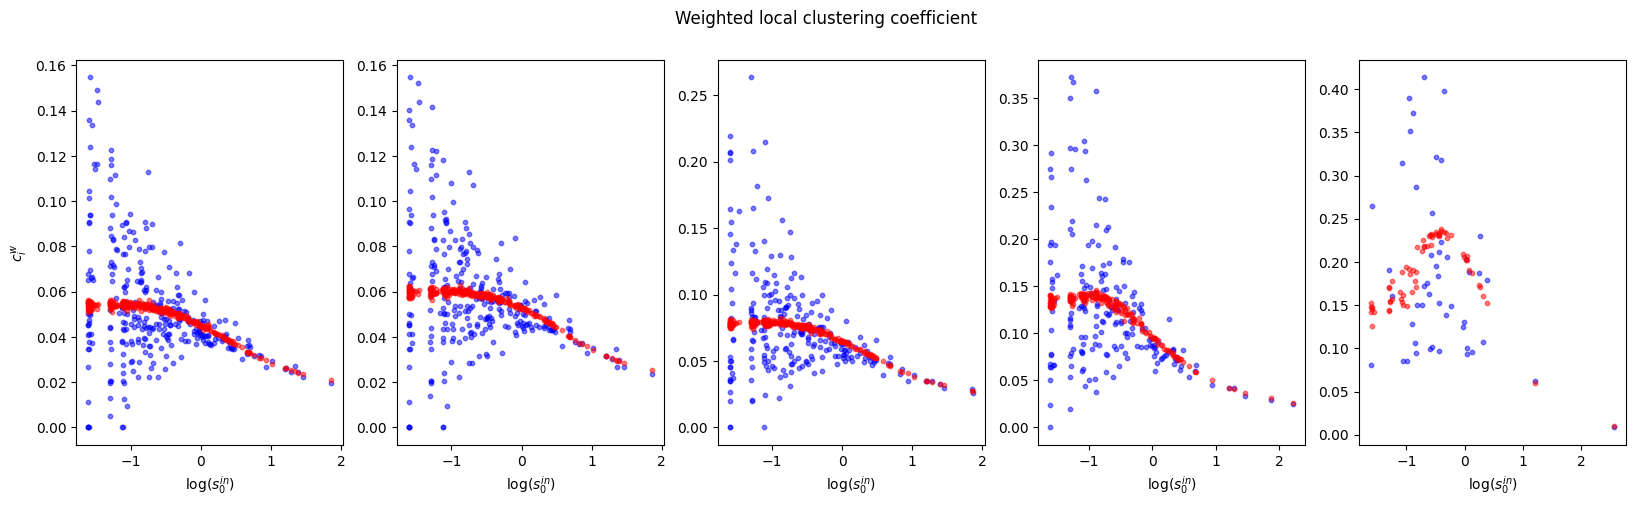

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Weighted local clustering coefficient')

ax1.scatter(np.log10(in_strengths), network_properties.weighted_clustering_coeff(original_graph), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), exp_weighted_cl_coeff, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$c_i^w$")

ax2.scatter(np.log10(in_strengths_50), network_properties.weighted_clustering_coeff(coarse_grained_original_50), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), exp_weighted_cl_coeff_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.weighted_clustering_coeff(coarse_grained_original_100), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), exp_weighted_cl_coeff_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.weighted_clustering_coeff(coarse_grained_original_200), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), exp_weighted_cl_coeff_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.weighted_clustering_coeff(coarse_grained_original_400), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), exp_weighted_cl_coeff_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

### High-level coarse-graining

In [ ]:
hl_coarse_grained_ensemble_50 = renormalizable_model.generate_RM_ensemble(1000, coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 50)), exp_z, weighted=True)
hl_coarse_grained_ensemble_100 = renormalizable_model.generate_RM_ensemble(1000, coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 100)), exp_z, weighted=True)
hl_coarse_grained_ensemble_200 = renormalizable_model.generate_RM_ensemble(1000, coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 200)), exp_z, weighted=True)
hl_coarse_grained_ensemble_400 = renormalizable_model.generate_RM_ensemble(1000, coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 400)), exp_z, weighted=True)

 74%|███████▎  | 735/1000 [01:52<00:40,  6.53it/s]


KeyboardInterrupt: 

#### Degrees

In [ ]:
hl_exp_degrees_out = np.nanmean([graph.degree(mode="out") for graph in ensemble], axis=0)
hl_exp_degrees_out_50 = np.nanmean([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_exp_degrees_out_100 = np.nanmean([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_exp_degrees_out_200 = np.nanmean([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_exp_degrees_out_400 = np.nanmean([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3850525179.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), original_graph.degree(mode="out"), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3850525179.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), hl_exp_degrees_out, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3850525179.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), coarse_grained_original_50.degree(mode="out"), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3850525179.py:10: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), hl_exp_degrees_out_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/385052517

[Text(0.5, 0, '$\\log(s_0^{out})$')]

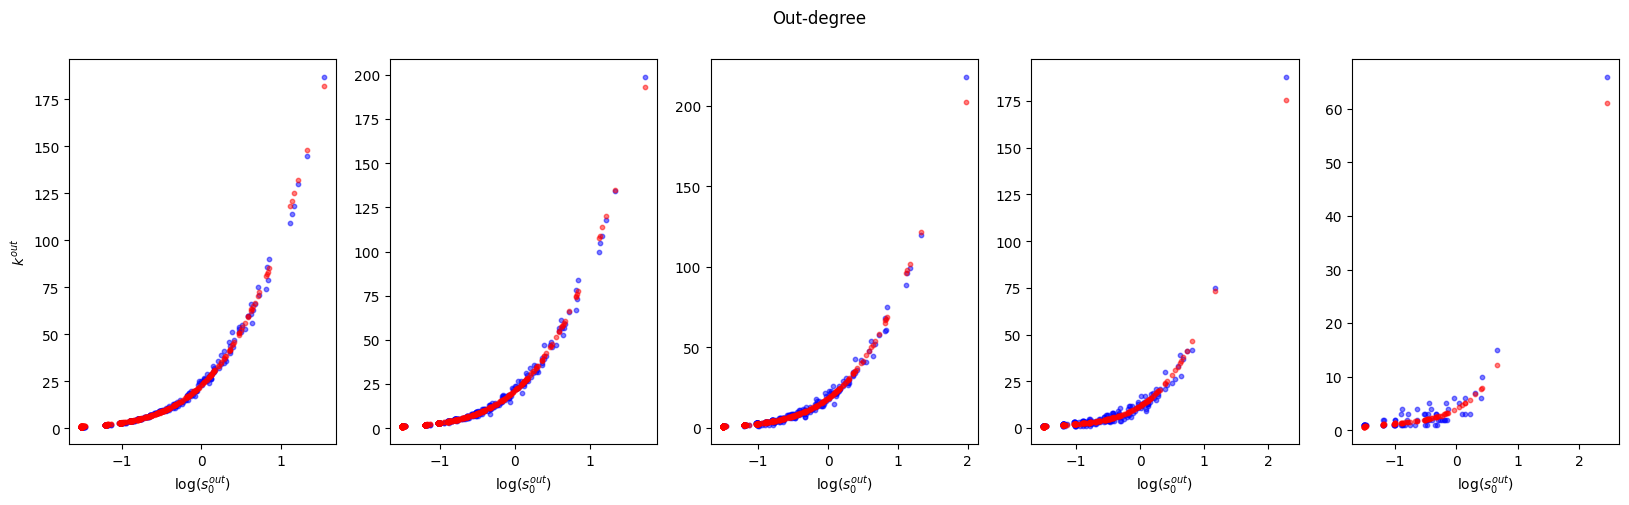

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Out-degree')


ax1.scatter(np.log10(out_strengths), original_graph.degree(mode="out"), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(out_strengths), hl_exp_degrees_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{out})$", ylabel=r"$k^{out}$")

ax2.scatter(np.log10(out_strengths_50), coarse_grained_original_50.degree(mode="out"), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(out_strengths_50), hl_exp_degrees_out_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{out})$")

ax3.scatter(np.log10(out_strengths_100), coarse_grained_original_100.degree(mode="out"), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(out_strengths_100), hl_exp_degrees_out_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{out})$")

ax4.scatter(np.log10(out_strengths_200), coarse_grained_original_200.degree(mode="out"), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(out_strengths_200), hl_exp_degrees_out_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{out})$")

ax5.scatter(np.log10(out_strengths_400), coarse_grained_original_400.degree(mode="out"), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(out_strengths_400), hl_exp_degrees_out_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{out})$")

In [ ]:
hl_exp_degrees_in = np.nanmean([graph.degree(mode="in") for graph in ensemble], axis=0)
hl_exp_degrees_in_50 = np.nanmean([graph.degree(mode="in") for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_exp_degrees_in_100 = np.nanmean([graph.degree(mode="in") for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_exp_degrees_in_200 = np.nanmean([graph.degree(mode="in") for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_exp_degrees_in_400 = np.nanmean([graph.degree(mode="in") for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1171893534.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), original_graph.degree(mode="in"), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1171893534.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), hl_exp_degrees_in, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1171893534.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), coarse_grained_original_50.degree(mode="in"), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1171893534.py:10: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), hl_exp_degrees_in_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1171893534.py:13:

[Text(0.5, 0, '$\\log(s_0^{in})$')]

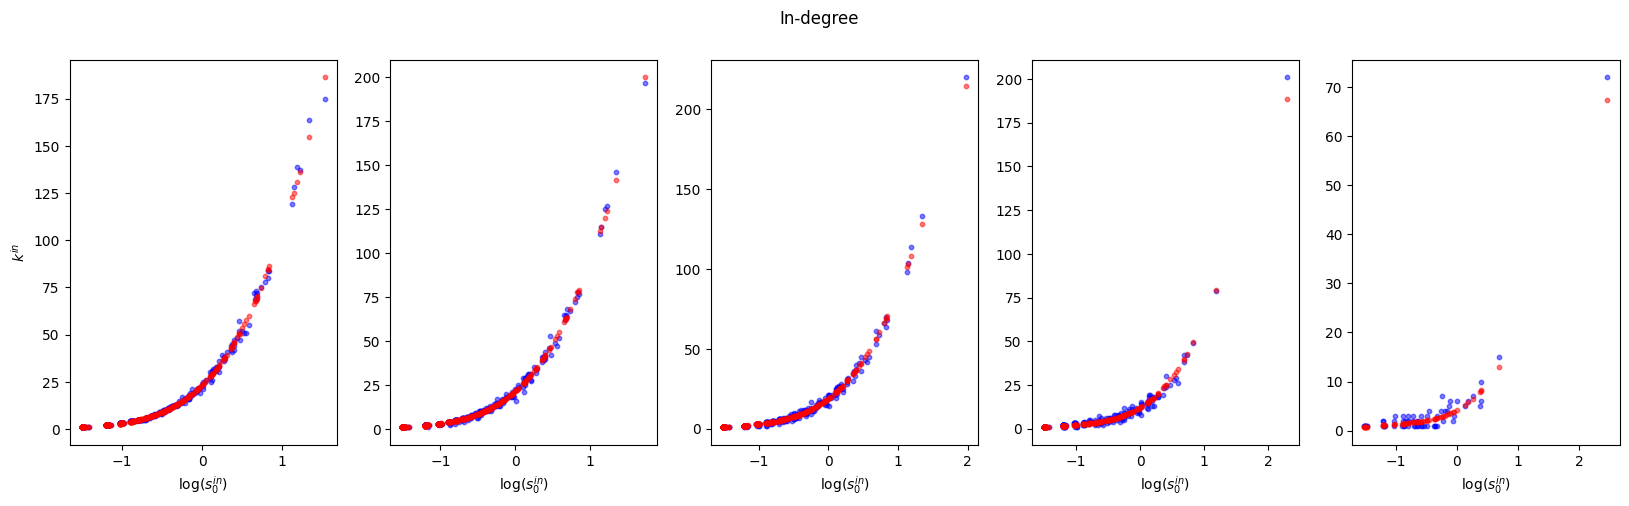

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('In-degree')


ax1.scatter(np.log10(in_strengths), original_graph.degree(mode="in"), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), hl_exp_degrees_in, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$k^{in}$")

ax2.scatter(np.log10(in_strengths_50), coarse_grained_original_50.degree(mode="in"), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), hl_exp_degrees_in_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), coarse_grained_original_100.degree(mode="in"), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), hl_exp_degrees_in_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), coarse_grained_original_200.degree(mode="in"), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), hl_exp_degrees_in_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), coarse_grained_original_400.degree(mode="in"), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), hl_exp_degrees_in_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

#### Strengths

In [ ]:
hl_exp_strengths_out = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in ensemble], axis=0)
hl_exp_strengths_out_50 = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_exp_strengths_out_100 = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_exp_strengths_out_200 = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_exp_strengths_out_400 = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3131370803.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), original_graph.strength(mode="out", weights=original_graph.es["weight"]), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3131370803.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), hl_exp_strengths_out, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3131370803.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), coarse_grained_original_50.strength(mode="out", weights=coarse_grained_original_50.es["weight"]), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3131370803.py:10: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), hl_exp_strengths_out_50, c="re

[Text(0.5, 0, '$\\log(s_0^{out})$'), None]

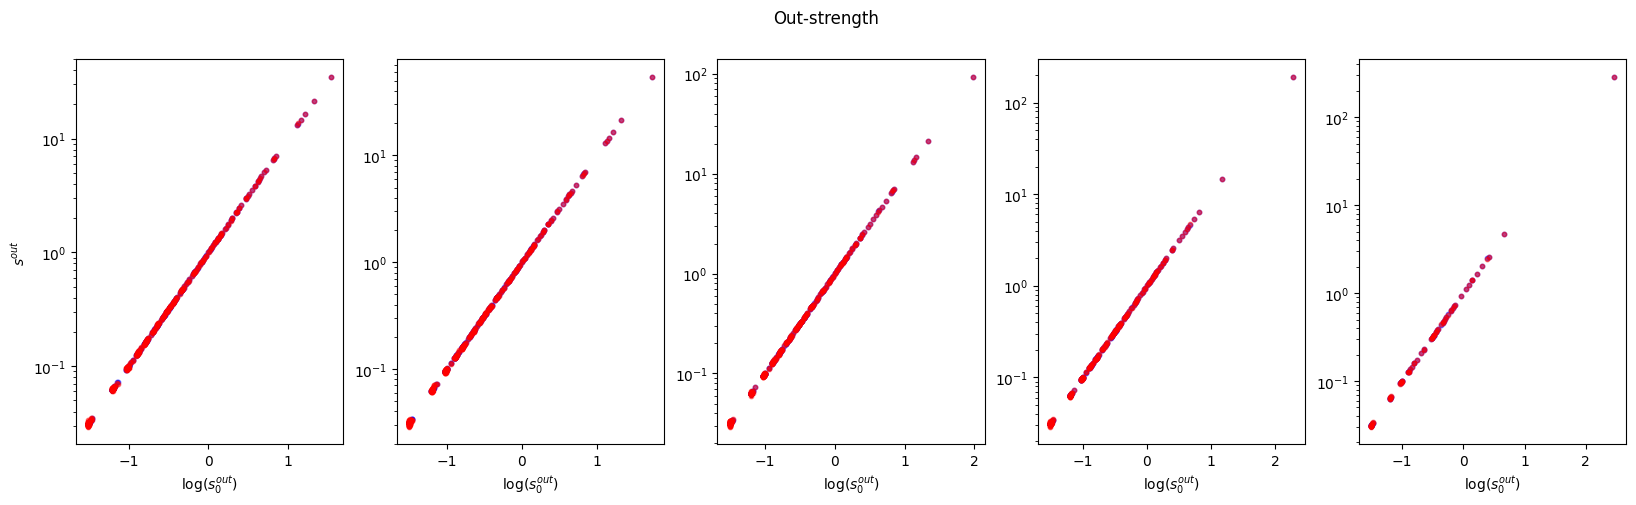

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Out-strength')


ax1.scatter(np.log10(out_strengths), original_graph.strength(mode="out", weights=original_graph.es["weight"]), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(out_strengths), hl_exp_strengths_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{out})$", ylabel=r"$s^{out}$", yscale="log")

ax2.scatter(np.log10(out_strengths_50), coarse_grained_original_50.strength(mode="out", weights=coarse_grained_original_50.es["weight"]), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(out_strengths_50), hl_exp_strengths_out_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{out})$", yscale="log")

ax3.scatter(np.log10(out_strengths_100), coarse_grained_original_100.strength(mode="out", weights=coarse_grained_original_100.es["weight"]), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(out_strengths_100), hl_exp_strengths_out_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{out})$", yscale="log")

ax4.scatter(np.log10(out_strengths_200), coarse_grained_original_200.strength(mode="out", weights=coarse_grained_original_200.es["weight"]), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(out_strengths_200), hl_exp_strengths_out_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{out})$", yscale="log")

ax5.scatter(np.log10(out_strengths_400), coarse_grained_original_400.strength(mode="out", weights=coarse_grained_original_400.es["weight"]), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(out_strengths_400), hl_exp_strengths_out_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{out})$", yscale="log")

In [ ]:
hl_exp_strengths_in = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in ensemble], axis=0)
hl_exp_strengths_in_50 = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_exp_strengths_in_100 = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_exp_strengths_in_200 = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_exp_strengths_in_400 = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3497945562.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), original_graph.strength(mode="in", weights=original_graph.es["weight"]), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3497945562.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), hl_exp_strengths_in, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3497945562.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), coarse_grained_original_50.strength(mode="in", weights=coarse_grained_original_50.es["weight"]), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3497945562.py:10: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), hl_exp_strengths_in_50, c="red", s=10

[Text(0.5, 0, '$\\log(s_0^{in})$'), None]

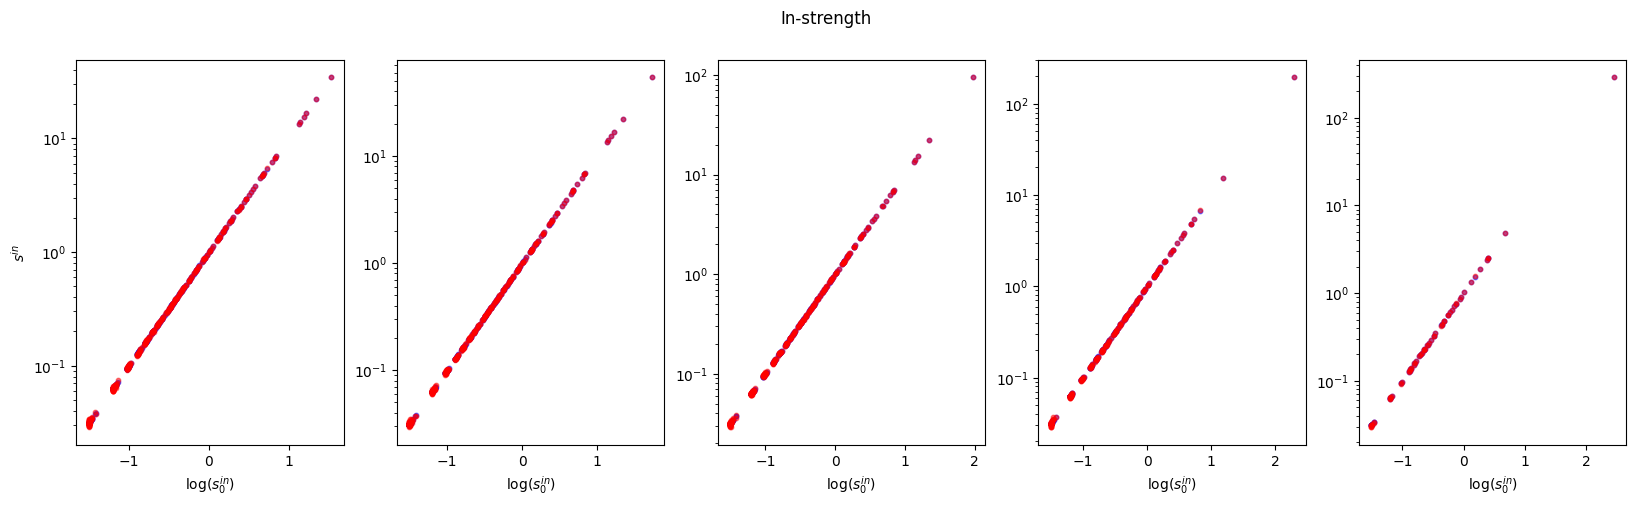

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('In-strength')


ax1.scatter(np.log10(in_strengths), original_graph.strength(mode="in", weights=original_graph.es["weight"]), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), hl_exp_strengths_in, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$s^{in}$", yscale="log")

ax2.scatter(np.log10(in_strengths_50), coarse_grained_original_50.strength(mode="in", weights=coarse_grained_original_50.es["weight"]), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), hl_exp_strengths_in_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$", yscale="log")

ax3.scatter(np.log10(in_strengths_100), coarse_grained_original_100.strength(mode="in", weights=coarse_grained_original_100.es["weight"]), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), hl_exp_strengths_in_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$", yscale="log")

ax4.scatter(np.log10(in_strengths_200), coarse_grained_original_200.strength(mode="in", weights=coarse_grained_original_200.es["weight"]), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), hl_exp_strengths_in_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$", yscale="log")

ax5.scatter(np.log10(in_strengths_400), coarse_grained_original_400.strength(mode="in", weights=coarse_grained_original_400.es["weight"]), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), hl_exp_strengths_in_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$", yscale="log")

#### Average nearest neighbor degree

In [ ]:
hl_exp_annd_out = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in ensemble], axis=0)
hl_exp_annd_out_50 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_exp_annd_out_100 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_exp_annd_out_200 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_exp_annd_out_400 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_400], axis=0)

/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:19: RuntimeWarning: invalid value encountered in divide
  annd_k = annd_k/degree_hist
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/603284024.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_annd_out = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in ensemble], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/603284024.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_annd_out_50 = np.nanmean([network_pr

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1733561965.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), network_properties.annd(original_graph, mode="out")[0], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1733561965.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), hl_exp_annd_out, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1733561965.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), network_properties.annd(coarse_grained_original_50, mode="out")[0], s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1733561965.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), hl_exp_annd_out_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x

[Text(0.5, 0, '$\\log(s_0^{out})$')]

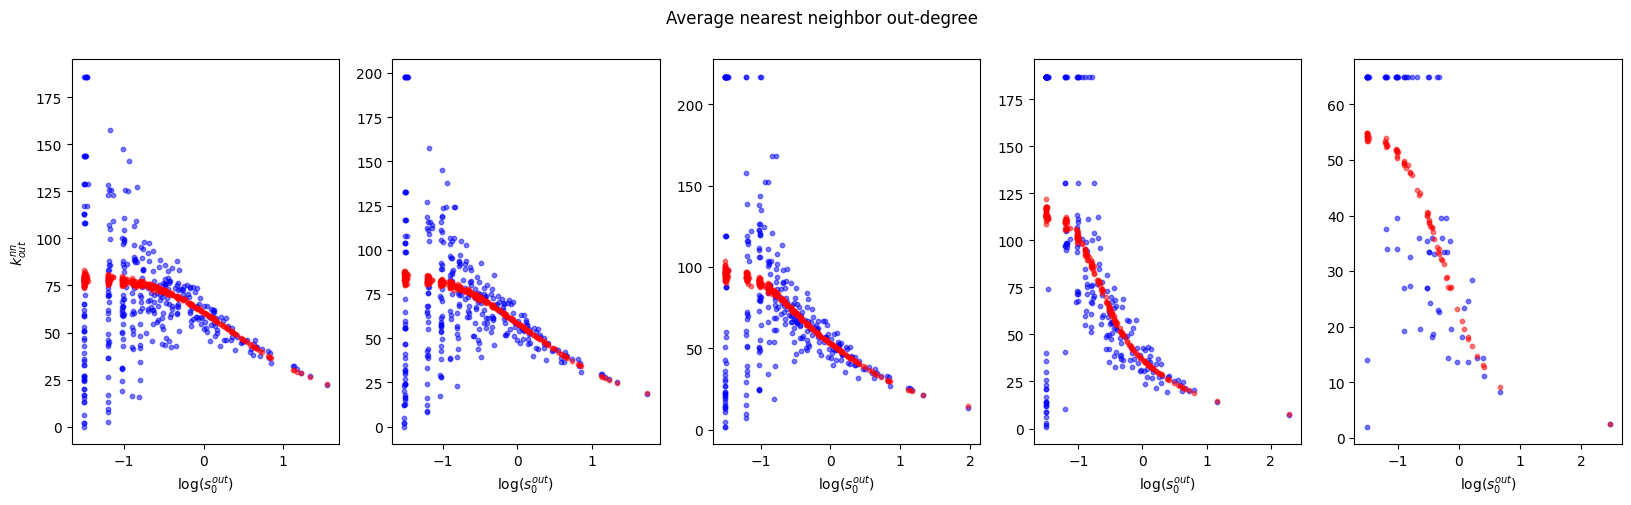

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average nearest neighbor out-degree')

ax1.scatter(np.log10(out_strengths), network_properties.annd(original_graph, mode="out")[0], s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(out_strengths), hl_exp_annd_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{out})$", ylabel=r"$k^{nn}_{out}$")

ax2.scatter(np.log10(out_strengths_50), network_properties.annd(coarse_grained_original_50, mode="out")[0], s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(out_strengths_50), hl_exp_annd_out_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{out})$")

ax3.scatter(np.log10(out_strengths_100), network_properties.annd(coarse_grained_original_100, mode="out")[0], s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(out_strengths_100), hl_exp_annd_out_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{out})$")

ax4.scatter(np.log10(out_strengths_200), network_properties.annd(coarse_grained_original_200, mode="out")[0], s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(out_strengths_200), hl_exp_annd_out_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{out})$")

ax5.scatter(np.log10(out_strengths_400), network_properties.annd(coarse_grained_original_400, mode="out")[0], s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(out_strengths_400), hl_exp_annd_out_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{out})$")

In [ ]:
hl_exp_annd_in = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in ensemble], axis=0)
hl_exp_annd_in_50 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_exp_annd_in_100 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_exp_annd_in_200 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_exp_annd_in_400 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/307500238.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_annd_in = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in ensemble], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/307500238.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_annd_in_50 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_50], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/307500238.py:3: RuntimeWarning: Mean of empty slice
  hl_exp_annd_in_100 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_100], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/307500238.py:4: RuntimeWarning: Mean of empty slice
  hl_exp_annd_in_200 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_200], axis=0)
/var/folders/td/zvch62c1

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2254953186.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.annd(original_graph, mode="in")[0], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2254953186.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), exp_annd_in, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2254953186.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.annd(coarse_grained_original_50, mode="in")[0], s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2254953186.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), hl_exp_annd_in_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/i

[Text(0.5, 0, '$\\log(s_0^{in})$')]

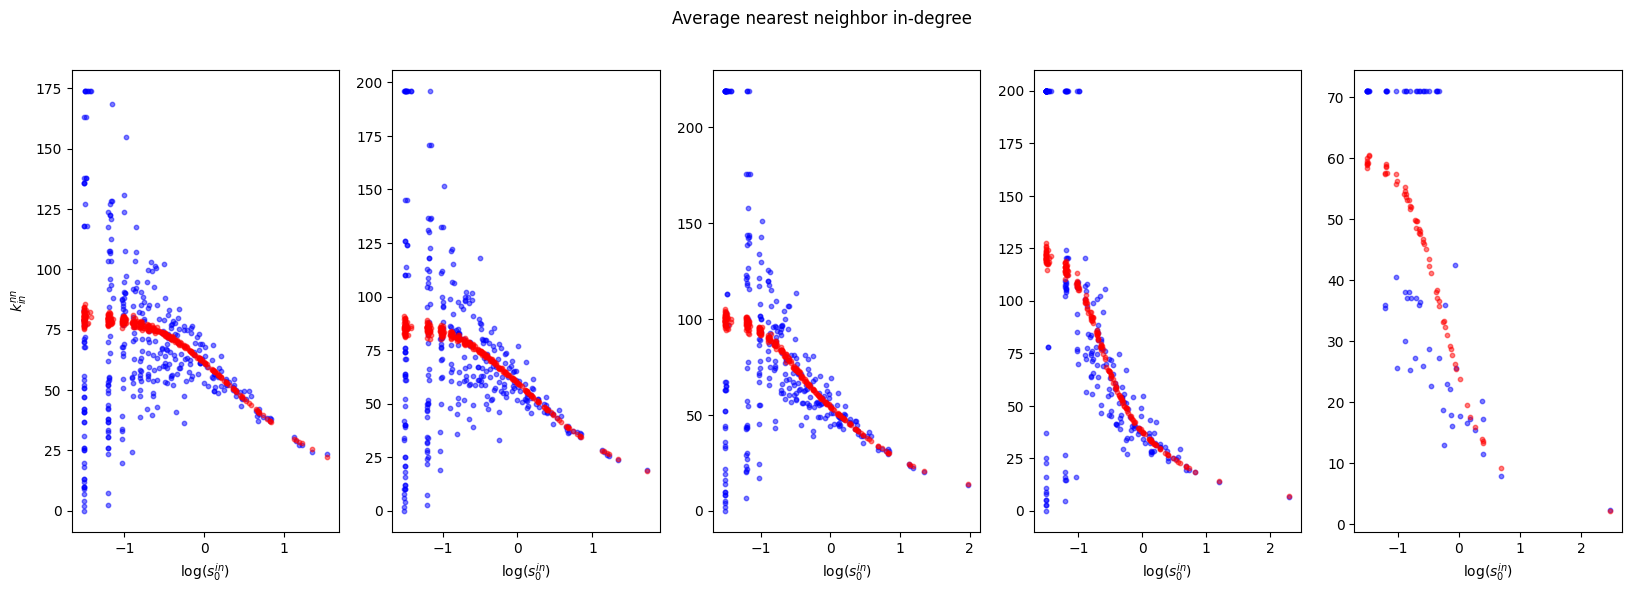

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle('Average nearest neighbor in-degree')

ax1.scatter(np.log10(in_strengths), network_properties.annd(original_graph, mode="in")[0], s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), exp_annd_in, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$k^{nn}_{in}$")

ax2.scatter(np.log10(in_strengths_50), network_properties.annd(coarse_grained_original_50, mode="in")[0], s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), hl_exp_annd_in_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.annd(coarse_grained_original_100, mode="in")[0], s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), hl_exp_annd_in_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.annd(coarse_grained_original_200, mode="in")[0], s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), hl_exp_annd_in_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.annd(coarse_grained_original_400, mode="in")[0], s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), hl_exp_annd_in_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

In [ ]:
hl_exp_anns_out = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(ensemble)], axis=0)
hl_exp_anns_out_50 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(hl_coarse_grained_ensemble_50)], axis=0)
hl_exp_anns_out_100 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(hl_coarse_grained_ensemble_100)], axis=0)
hl_exp_anns_out_200 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(hl_coarse_grained_ensemble_200)], axis=0)
hl_exp_anns_out_400 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(hl_coarse_grained_ensemble_400)], axis=0)

100%|██████████| 1000/1000 [03:05<00:00,  5.38it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3389806027.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_anns_out = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(ensemble)], axis=0)
100%|██████████| 1000/1000 [02:37<00:00,  6.37it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3389806027.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_anns_out_50 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(hl_coarse_grained_ensemble_50)], axis=0)
100%|██████████| 1000/1000 [01:55<00:00,  8.66it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3389806027.py:3: RuntimeWarning: Mean of empty slice
  hl_exp_anns_out_100 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(hl_coarse_grained_ensemble_100)], axis=0)
100%|██████████| 1000/1000 [00:42<00:00, 23.51it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2045376728.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), network_properties.anns(original_graph, mode="out"), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2045376728.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), hl_exp_anns_out, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2045376728.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), network_properties.anns(coarse_grained_original_50, mode="out"), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2045376728.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), hl_exp_anns_out_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000g

[Text(0.5, 0, '$\\log(s_0^{out})$')]

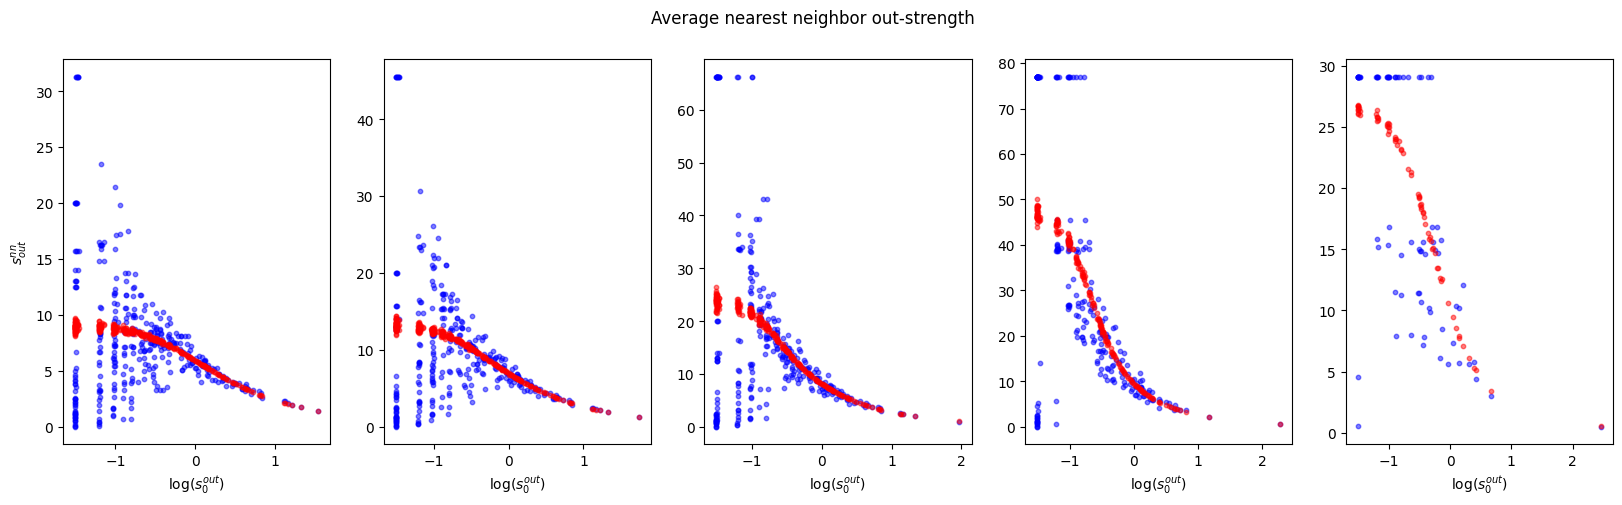

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average nearest neighbor out-strength')

ax1.scatter(np.log10(out_strengths), network_properties.anns(original_graph, mode="out"), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(out_strengths), hl_exp_anns_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{out})$", ylabel=r"$s^{nn}_{out}$")

ax2.scatter(np.log10(out_strengths_50), network_properties.anns(coarse_grained_original_50, mode="out"), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(out_strengths_50), hl_exp_anns_out_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{out})$")

ax3.scatter(np.log10(out_strengths_100), network_properties.anns(coarse_grained_original_100, mode="out"), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(out_strengths_100), hl_exp_anns_out_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{out})$")

ax4.scatter(np.log10(out_strengths_200), network_properties.anns(coarse_grained_original_200, mode="out"), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(out_strengths_200), hl_exp_anns_out_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{out})$")

ax5.scatter(np.log10(out_strengths_400), network_properties.anns(coarse_grained_original_400, mode="out"), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(out_strengths_400), hl_exp_anns_out_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{out})$")

In [ ]:
hl_exp_anns_in = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(ensemble)], axis=0)
hl_exp_anns_in_50 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(hl_coarse_grained_ensemble_50)], axis=0)
hl_exp_anns_in_100 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(hl_coarse_grained_ensemble_100)], axis=0)
hl_exp_anns_in_200 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(hl_coarse_grained_ensemble_200)], axis=0)
hl_exp_anns_in_400 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(hl_coarse_grained_ensemble_400)], axis=0)

100%|██████████| 1000/1000 [03:04<00:00,  5.42it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3556467246.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_anns_in = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(ensemble)], axis=0)
100%|██████████| 1000/1000 [02:33<00:00,  6.51it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3556467246.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_anns_in_50 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(hl_coarse_grained_ensemble_50)], axis=0)
100%|██████████| 1000/1000 [01:55<00:00,  8.69it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3556467246.py:3: RuntimeWarning: Mean of empty slice
  hl_exp_anns_in_100 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(hl_coarse_grained_ensemble_100)], axis=0)
100%|██████████| 1000/1000 [00:42<00:00, 23.37it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipyker

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1127010426.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.anns(original_graph, mode="in"), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1127010426.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), hl_exp_anns_in, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1127010426.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.anns(coarse_grained_original_50, mode="in"), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1127010426.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), hl_exp_anns_in_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipyk

[Text(0.5, 0, '$\\log(s_0^{in})$')]

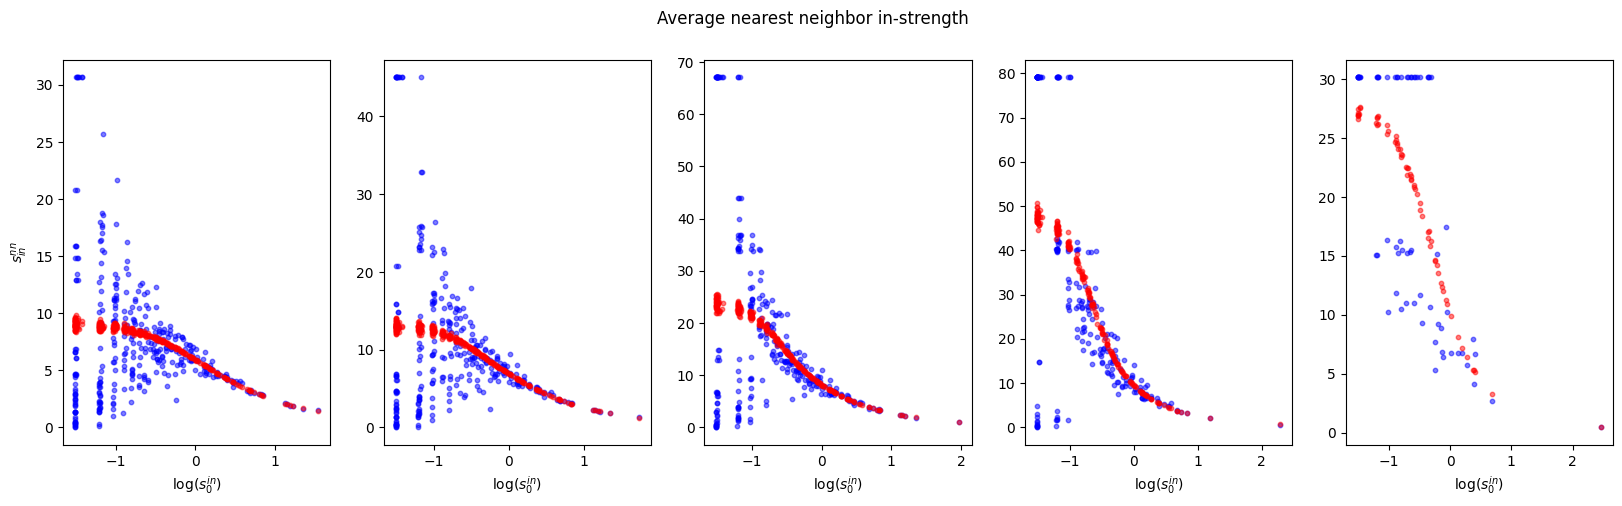

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average nearest neighbor in-strength')

ax1.scatter(np.log10(in_strengths), network_properties.anns(original_graph, mode="in"), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), hl_exp_anns_in, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$s^{nn}_{in}$")

ax2.scatter(np.log10(in_strengths_50), network_properties.anns(coarse_grained_original_50, mode="in"), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), hl_exp_anns_in_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.anns(coarse_grained_original_100, mode="in"), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), hl_exp_anns_in_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.anns(coarse_grained_original_200, mode="in"), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), hl_exp_anns_in_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.anns(coarse_grained_original_400, mode="in"), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), hl_exp_anns_in_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

#### Local clustering coefficient

In [ ]:
hl_exp_cl_coeff_results = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(ensemble)]
hl_exp_cl_coeff_results_50 = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(hl_coarse_grained_ensemble_50)]
hl_exp_cl_coeff_results_100 = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(hl_coarse_grained_ensemble_100)]
hl_exp_cl_coeff_results_200 = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(hl_coarse_grained_ensemble_200)]
hl_exp_cl_coeff_results_400 = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(hl_coarse_grained_ensemble_400)]

100%|██████████| 1000/1000 [00:03<00:00, 326.78it/s]


In [ ]:
hl_exp_cl_coeff = np.nanmean([hl_exp_cl_coeff_results[i][0] for i in range(len(hl_exp_cl_coeff_results))], axis=0)
hl_exp_cl_coeff_50 = np.nanmean([hl_exp_cl_coeff_results_50[i][0] for i in range(len(hl_exp_cl_coeff_results_50))], axis=0)
hl_exp_cl_coeff_100 = np.nanmean([hl_exp_cl_coeff_results_100[i][0] for i in range(len(hl_exp_cl_coeff_results_100))], axis=0)
hl_exp_cl_coeff_200 = np.nanmean([hl_exp_cl_coeff_results_200[i][0] for i in range(len(hl_exp_cl_coeff_results_200))], axis=0)
hl_exp_cl_coeff_400 = np.nanmean([hl_exp_cl_coeff_results_400[i][0] for i in range(len(hl_exp_cl_coeff_results_400))], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2351783483.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff = np.nanmean([hl_exp_cl_coeff_results[i][0] for i in range(len(hl_exp_cl_coeff_results))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2351783483.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_50 = np.nanmean([hl_exp_cl_coeff_results_50[i][0] for i in range(len(hl_exp_cl_coeff_results_50))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2351783483.py:3: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_100 = np.nanmean([hl_exp_cl_coeff_results_100[i][0] for i in range(len(hl_exp_cl_coeff_results_100))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2351783483.py:4: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_200 = np.nanmean([hl_exp_cl_coeff_results_200[i][0] for i in range(len(hl_exp_cl_coeff_results_200))], axis=0)
/var/folders/td/zvch62c16b7

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2851414236.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.clustering_coeff(original_graph,len_deg_seq=size)[0], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2851414236.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), hl_exp_cl_coeff, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2851414236.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.clustering_coeff(coarse_grained_original_50,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2851414236.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), hl_exp_cl_coeff_50, c="red", s=10, alpha=.5)
/var/fold

[Text(0.5, 0, '$\\log(s_0^{in})$')]

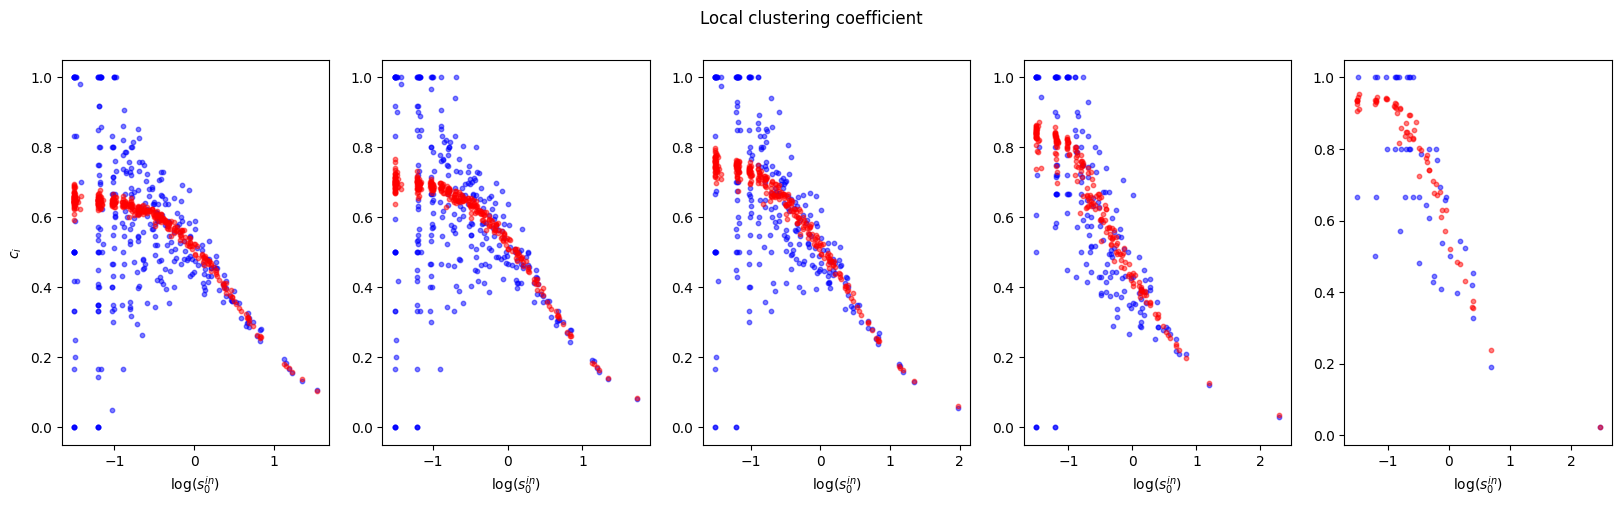

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Local clustering coefficient')

ax1.scatter(np.log10(in_strengths), network_properties.clustering_coeff(original_graph,len_deg_seq=size)[0], s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), hl_exp_cl_coeff, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$c_i$")

ax2.scatter(np.log10(in_strengths_50), network_properties.clustering_coeff(coarse_grained_original_50,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), hl_exp_cl_coeff_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.clustering_coeff(coarse_grained_original_100,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), hl_exp_cl_coeff_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.clustering_coeff(coarse_grained_original_200,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), hl_exp_cl_coeff_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.clustering_coeff(coarse_grained_original_400,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), hl_exp_cl_coeff_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

In [ ]:
hl_exp_cl_coeff_k = np.nanmean([hl_exp_cl_coeff_results[i][1] for i in range(len(hl_exp_cl_coeff_results))], axis=0)
hl_exp_cl_coeff_k_50 = np.nanmean([hl_exp_cl_coeff_results_50[i][1] for i in range(len(hl_exp_cl_coeff_results_50))], axis=0)
hl_exp_cl_coeff_k_100 = np.nanmean([hl_exp_cl_coeff_results_100[i][1] for i in range(len(hl_exp_cl_coeff_results_100))], axis=0)
hl_exp_cl_coeff_k_200 = np.nanmean([hl_exp_cl_coeff_results_200[i][1] for i in range(len(hl_exp_cl_coeff_results_200))], axis=0)
hl_exp_cl_coeff_k_400 = np.nanmean([hl_exp_cl_coeff_results_400[i][1] for i in range(len(hl_exp_cl_coeff_results_400))], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2039684858.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_k = np.nanmean([hl_exp_cl_coeff_results[i][1] for i in range(len(hl_exp_cl_coeff_results))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2039684858.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_k_50 = np.nanmean([hl_exp_cl_coeff_results_50[i][1] for i in range(len(hl_exp_cl_coeff_results_50))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2039684858.py:3: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_k_100 = np.nanmean([hl_exp_cl_coeff_results_100[i][1] for i in range(len(hl_exp_cl_coeff_results_100))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2039684858.py:4: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_k_200 = np.nanmean([hl_exp_cl_coeff_results_200[i][1] for i in range(len(hl_exp_cl_coeff_results_200))], axis=0)
/var/folders/td/zvc

In [ ]:
obs_cl_coeff_k = network_properties.clustering_coeff(original_graph,len_deg_seq=size)[1]
obs_cl_coeff_k_50 = network_properties.clustering_coeff(coarse_grained_original_50,len_deg_seq=size)[1]
obs_cl_coeff_k_100 = network_properties.clustering_coeff(coarse_grained_original_100,len_deg_seq=size)[1]
obs_cl_coeff_k_200 = network_properties.clustering_coeff(coarse_grained_original_200,len_deg_seq=size)[1]
obs_cl_coeff_k_400 = network_properties.clustering_coeff(coarse_grained_original_400,len_deg_seq=size)[1]

[Text(0.5, 0, '$k$'), None, None]

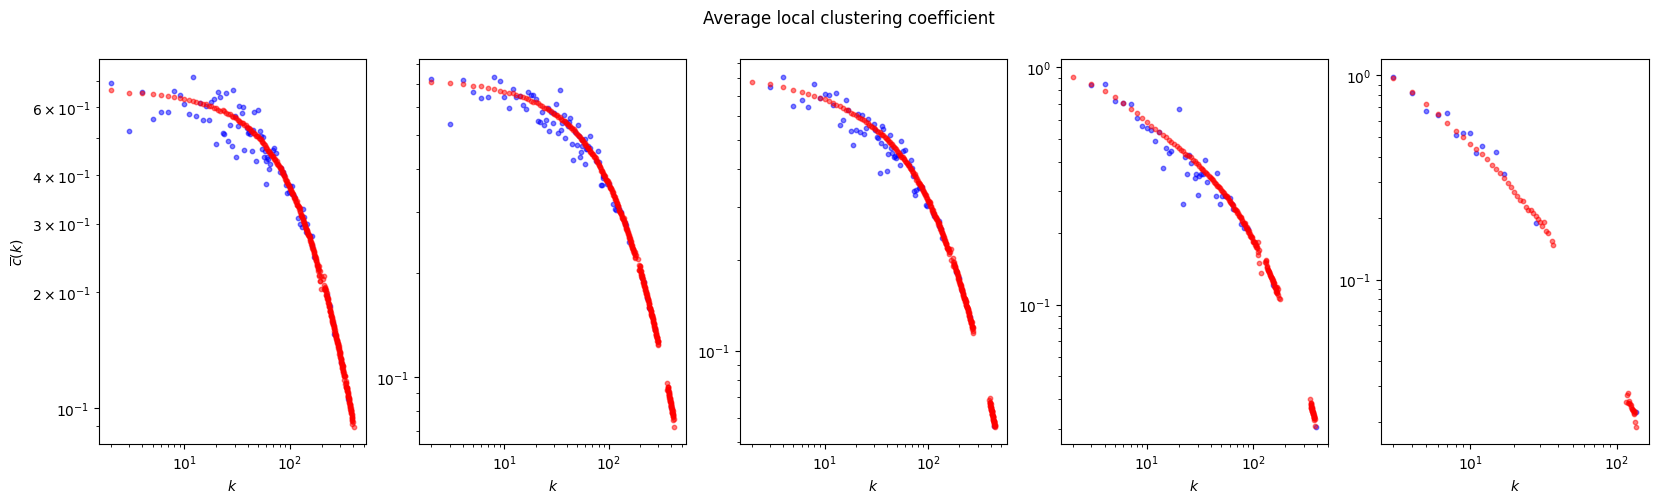

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average local clustering coefficient')

ax1.scatter(range(1, len(obs_cl_coeff_k)+1), obs_cl_coeff_k, s=10, c="blue", alpha=.5)
ax1.scatter(range(1, len(hl_exp_cl_coeff_k)+1), hl_exp_cl_coeff_k, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$k$", ylabel=r'$\overline{c}(k)$', xscale="log", yscale="log")

ax2.scatter(range(1, len(obs_cl_coeff_k_50)+1), obs_cl_coeff_k_50, s=10, c="blue", alpha=.5)
ax2.scatter(range(1, len(hl_exp_cl_coeff_k_50)+1), hl_exp_cl_coeff_k_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$k$", xscale="log", yscale="log")

ax3.scatter(range(1, len(obs_cl_coeff_k_100)+1), obs_cl_coeff_k_100, s=10, c="blue", alpha=.5)
ax3.scatter(range(1, len(hl_exp_cl_coeff_k_100)+1), hl_exp_cl_coeff_k_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$k$", xscale="log", yscale="log")

ax4.scatter(range(1, len(obs_cl_coeff_k_200)+1), obs_cl_coeff_k_200, s=10, c="blue", alpha=.5)
ax4.scatter(range(1, len(hl_exp_cl_coeff_k_200)+1), hl_exp_cl_coeff_k_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$k$", xscale="log", yscale="log")

ax5.scatter(range(1, len(obs_cl_coeff_k_400)+1), obs_cl_coeff_k_400, s=10, c="blue", alpha=.5)
ax5.scatter(range(1, len(hl_exp_cl_coeff_k_400)+1), hl_exp_cl_coeff_k_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$k$", xscale="log", yscale="log")

#### Weighted local clustering coefficient

In [ ]:
hl_exp_weighted_cl_coeff = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(ensemble)], axis=0)
hl_exp_weighted_cl_coeff_50 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(hl_coarse_grained_ensemble_50)], axis=0)
hl_exp_weighted_cl_coeff_100 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(hl_coarse_grained_ensemble_100)], axis=0)
hl_exp_weighted_cl_coeff_200 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(hl_coarse_grained_ensemble_200)], axis=0)
hl_exp_weighted_cl_coeff_400 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(hl_coarse_grained_ensemble_400)], axis=0)

100%|██████████| 1000/1000 [02:44<00:00,  6.07it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2481365804.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_weighted_cl_coeff = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(ensemble)], axis=0)
100%|██████████| 1000/1000 [02:11<00:00,  7.63it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2481365804.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_weighted_cl_coeff_50 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(hl_coarse_grained_ensemble_50)], axis=0)
100%|██████████| 1000/1000 [01:29<00:00, 11.23it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2481365804.py:3: RuntimeWarning: Mean of empty slice
  hl_exp_weighted_cl_coeff_100 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(hl_coarse_grained_ensemble_100)], axis=0)
100%|██████████| 1000/1000 [00:24<00:00, 41.09i

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1253335618.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.weighted_clustering_coeff(original_graph), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1253335618.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), hl_exp_weighted_cl_coeff, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1253335618.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.weighted_clustering_coeff(coarse_grained_original_50), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1253335618.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), hl_exp_weighted_cl_coeff_50, c="red", s=10, alpha=.5)
/var/folders/

[Text(0.5, 0, '$\\log(s_0^{in})$')]

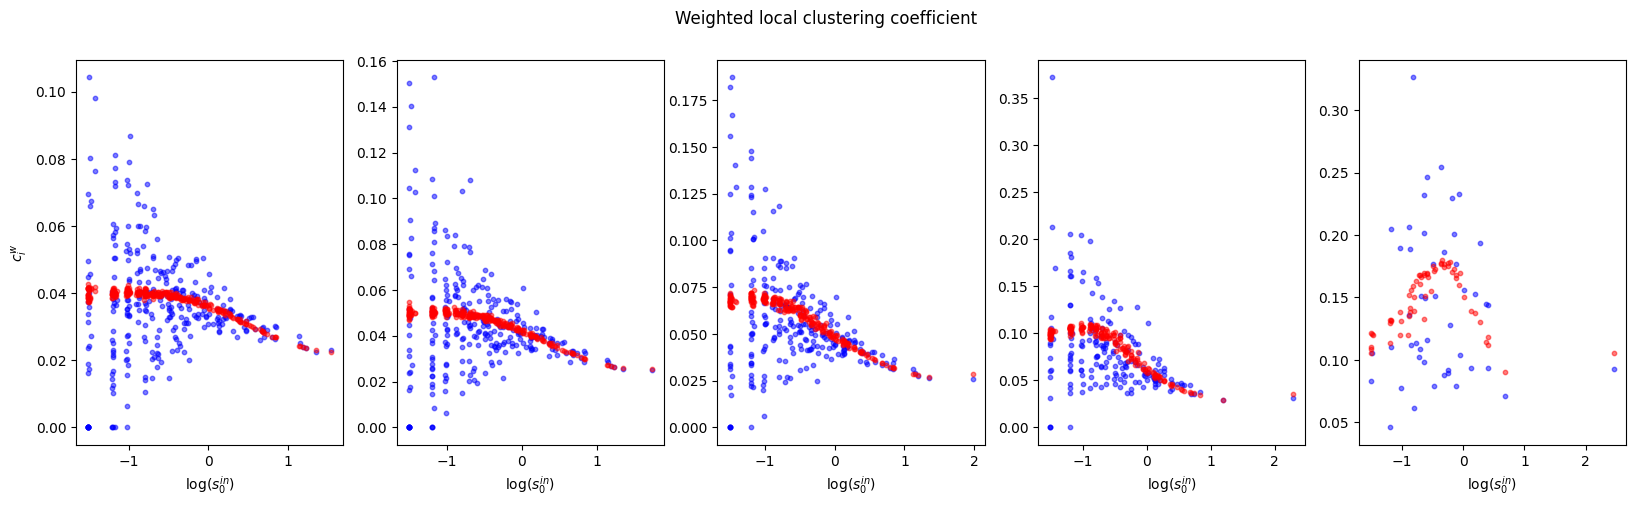

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Weighted local clustering coefficient')

ax1.scatter(np.log10(in_strengths), network_properties.weighted_clustering_coeff(original_graph), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), hl_exp_weighted_cl_coeff, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$c_i^w$")

ax2.scatter(np.log10(in_strengths_50), network_properties.weighted_clustering_coeff(coarse_grained_original_50), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), hl_exp_weighted_cl_coeff_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.weighted_clustering_coeff(coarse_grained_original_100), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), hl_exp_weighted_cl_coeff_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.weighted_clustering_coeff(coarse_grained_original_200), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), hl_exp_weighted_cl_coeff_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.weighted_clustering_coeff(coarse_grained_original_400), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), hl_exp_weighted_cl_coeff_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

## Compare low-level and high-level coarsegraining

### Degrees

In [ ]:
ll_std_degrees_out = np.nanstd([graph.degree(mode="out") for graph in ensemble], axis=0)
ll_std_degrees_out_50 = np.nanstd([graph.degree(mode="out") for graph in coarse_grained_ensemble_50], axis=0)
ll_std_degrees_out_100 = np.nanstd([graph.degree(mode="out") for graph in coarse_grained_ensemble_100], axis=0)
ll_std_degrees_out_200 = np.nanstd([graph.degree(mode="out") for graph in coarse_grained_ensemble_200], axis=0)
ll_std_degrees_out_400 = np.nanstd([graph.degree(mode="out") for graph in coarse_grained_ensemble_400], axis=0)

In [ ]:
hl_std_degrees_out = np.nanstd([graph.degree(mode="out") for graph in ensemble], axis=0)
hl_std_degrees_out_50 = np.nanstd([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_std_degrees_out_100 = np.nanstd([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_std_degrees_out_200 = np.nanstd([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_std_degrees_out_400 = np.nanstd([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/956606765.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_50), ll_std_degrees_out_50, s=10, alpha=.5, label="Low-level")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/956606765.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_50), hl_std_degrees_out_50, s=10, alpha=.5, label="High-level")


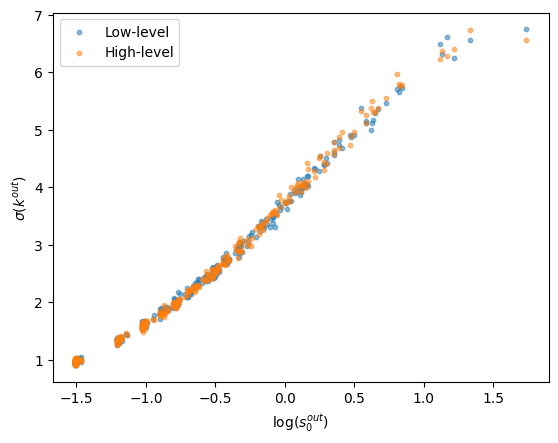

In [ ]:
plt.scatter(np.log10(out_strengths_50), ll_std_degrees_out_50, s=10, alpha=.5, label="Low-level")
plt.scatter(np.log10(out_strengths_50), hl_std_degrees_out_50, s=10, alpha=.5, label="High-level")
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$\sigma(k^{out})$")
plt.legend()

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/778241222.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_200), ll_std_degrees_out_200, s=10, alpha=.5, label="Low-level")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/778241222.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_200), hl_std_degrees_out_200, s=10, alpha=.5, label="High-level")


Text(0, 0.5, '$\\sigma(k^{out})$')

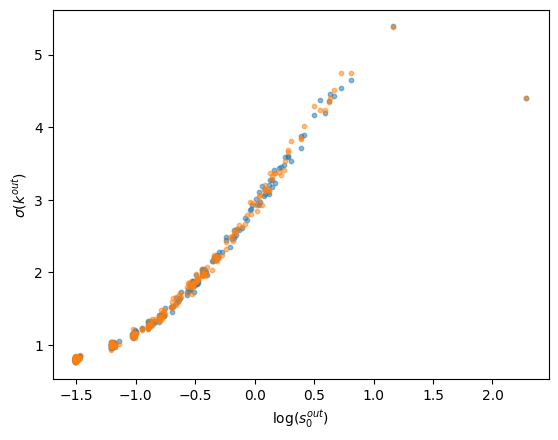

In [ ]:
plt.scatter(np.log10(out_strengths_200), ll_std_degrees_out_200, s=10, alpha=.5, label="Low-level")
plt.scatter(np.log10(out_strengths_200), hl_std_degrees_out_200, s=10, alpha=.5, label="High-level")
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$\sigma(k^{out})$")

### Average nearest neighbor degree

In [ ]:
ll_std_annd_out = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in ensemble], axis=0)
ll_std_annd_out_50 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_50], axis=0)
ll_std_annd_out_100 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_100], axis=0)
ll_std_annd_out_200 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_200], axis=0)
ll_std_annd_out_400 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_400], axis=0)

/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:19: RuntimeWarning: invalid value encountered in divide
  annd_k = annd_k/degree_hist
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
hl_std_annd_out = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in ensemble], axis=0)
hl_std_annd_out_50 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_std_annd_out_100 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_std_annd_out_200 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_std_annd_out_400 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1310423869.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_50), ll_std_annd_out_50, s=10, alpha=.5, label="Low-level")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1310423869.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_50), hl_std_annd_out_50, s=10, alpha=.5, label="High-level")


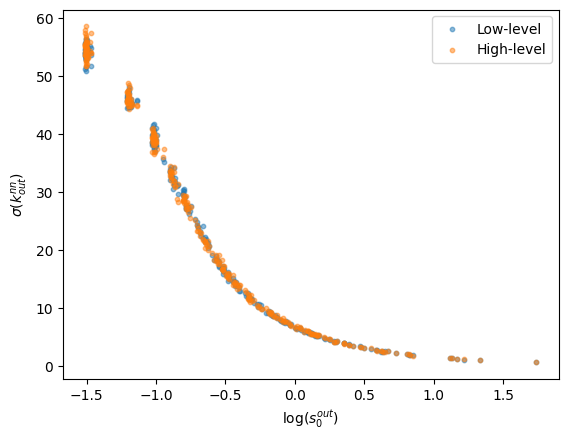

In [ ]:
plt.scatter(np.log10(out_strengths_50), ll_std_annd_out_50, s=10, alpha=.5, label="Low-level")
plt.scatter(np.log10(out_strengths_50), hl_std_annd_out_50, s=10, alpha=.5, label="High-level")
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$\sigma(k^{nn}_{out})$")
plt.legend()

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3880192418.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_400), ll_std_annd_out_400, s=10, alpha=.5, label="Low-level")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3880192418.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_400), hl_std_annd_out_400, s=10, alpha=.5, label="High-level")


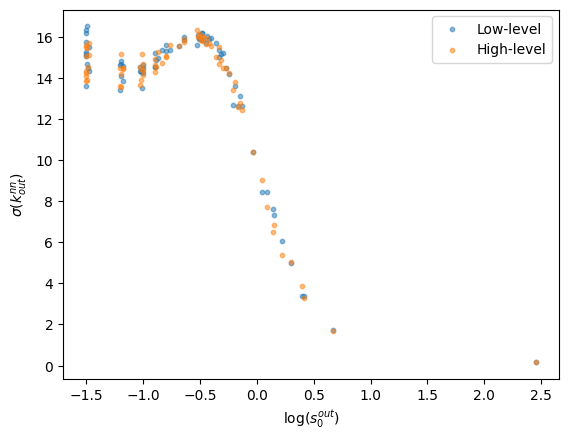

In [ ]:
plt.scatter(np.log10(out_strengths_400), ll_std_annd_out_400, s=10, alpha=.5, label="Low-level")
plt.scatter(np.log10(out_strengths_400), hl_std_annd_out_400, s=10, alpha=.5, label="High-level")
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$\sigma(k^{nn}_{out})$")
plt.legend()

### Local clustering coefficient

In [ ]:
ll_std_cl_coeff = np.nanstd([exp_cl_coeff_results[i][0] for i in range(len(exp_cl_coeff_results))], axis=0)
ll_std_cl_coeff_50 = np.nanstd([exp_cl_coeff_results_50[i][0] for i in range(len(exp_cl_coeff_results_50))], axis=0)
ll_std_cl_coeff_100 = np.nanstd([exp_cl_coeff_results_100[i][0] for i in range(len(exp_cl_coeff_results_100))], axis=0)
ll_std_cl_coeff_200 = np.nanstd([exp_cl_coeff_results_200[i][0] for i in range(len(exp_cl_coeff_results_200))], axis=0)
ll_std_cl_coeff_400 = np.nanstd([exp_cl_coeff_results_400[i][0] for i in range(len(exp_cl_coeff_results_400))], axis=0)

/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
hl_std_cl_coeff = np.nanstd([hl_exp_cl_coeff_results[i][0] for i in range(len(hl_exp_cl_coeff_results))], axis=0)
hl_std_cl_coeff_50 = np.nanstd([hl_exp_cl_coeff_results_50[i][0] for i in range(len(hl_exp_cl_coeff_results_50))], axis=0)
hl_std_cl_coeff_100 = np.nanstd([hl_exp_cl_coeff_results_100[i][0] for i in range(len(hl_exp_cl_coeff_results_100))], axis=0)
hl_std_cl_coeff_200 = np.nanstd([hl_exp_cl_coeff_results_200[i][0] for i in range(len(hl_exp_cl_coeff_results_200))], axis=0)
hl_std_cl_coeff_400 = np.nanstd([hl_exp_cl_coeff_results_400[i][0] for i in range(len(hl_exp_cl_coeff_results_400))], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1258526679.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_50), ll_std_cl_coeff_50, s=10, alpha=.5, label="Low-level")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1258526679.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_50), hl_std_cl_coeff_50, s=10, alpha=.5, label="High-level")


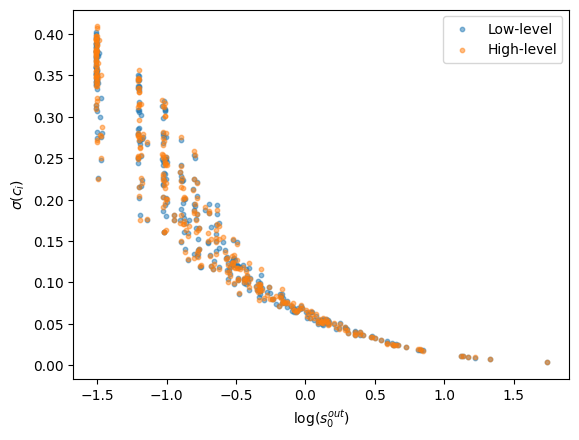

In [ ]:
plt.scatter(np.log10(out_strengths_50), ll_std_cl_coeff_50, s=10, alpha=.5, label="Low-level")
plt.scatter(np.log10(out_strengths_50), hl_std_cl_coeff_50, s=10, alpha=.5, label="High-level")
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$\sigma(c_i)$")
plt.legend()

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3330423892.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_400), ll_std_cl_coeff_400, s=10, alpha=.5, label="Low-level")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3330423892.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_400), hl_std_cl_coeff_400, s=10, alpha=.5, label="High-level")


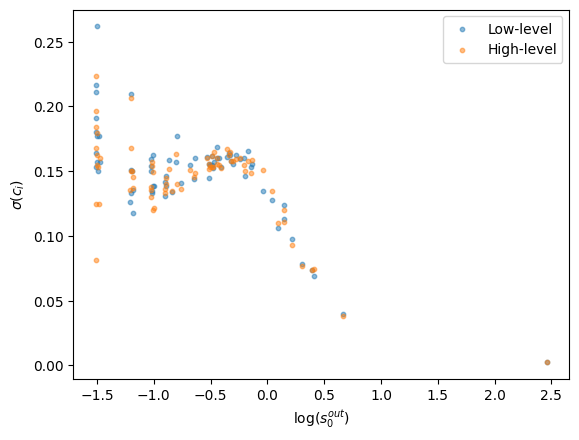

In [ ]:
plt.scatter(np.log10(out_strengths_400), ll_std_cl_coeff_400, s=10, alpha=.5, label="Low-level")
plt.scatter(np.log10(out_strengths_400), hl_std_cl_coeff_400, s=10, alpha=.5, label="High-level")
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$\sigma(c_i)$")
plt.legend()